## Import Package

In [2]:
import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from scipy import stats

## time series models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pyramid.arima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [ ]:
print(pd.__version__)
print(np.__version__)
print(sns.__version__)

In [ ]:
def test_stationarity(timeseries, win_days):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=win_days).mean()
    rolstd = timeseries.rolling(window=win_days).std()

    #Plot rolling statistics:
    fig, ax = plt.subplots(figsize=(15,4))
    
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(str(win_days) + '_Days Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

## I. Read Files

First step, check variables. `dataset_transaction` and `dataset_user` state for training set, which is not important so 5 variables will apply into the prediction model. The purpose for this case is predicting revenue and expenses for Aug 2016. Therefore, I would like to cover some ideas and steps to do:


1. Split up transaction data for `revenue` and `expenses`.
2. Group the data points by daily basis. I like to collect the daily pattern of user revenue and expenses to train the model.
3. As we like to validate the model performance, so we need to split data set for training set and testing set. 5 months for training sets and 1 month for testing sets
4. In order to reduce over-fitting issues for small size data set, will apply cross validation methods for data.


In [ ]:
df_raw = pd.read_csv('../data/df_raw.csv')
trans_type = pd.read_csv('../data/transaction_types.csv')
mcc_group = pd.read_csv('../data/mcc_group_definition.csv')

##### merge train set and meta data for EDA later to understand variables better

In [5]:
df_merge_meta = df_raw.set_index('mcc_group').join(mcc_group.set_index('mcc_group')).reset_index()
df_merge_meta = df_merge_meta.set_index('transaction_type').join(
    trans_type.rename(columns={'explanation':'explanation_trans','type':'transaction_type'}).set_index('transaction_type')
).reset_index()

In [6]:
df_merge_meta.head(2)

,transaction_type,mcc_group,user_id,transaction_date,amount_n26_currency,dataset_transaction,dataset_user,explanation,explanation_trans,direction,agent
0,BBU,NaN,d629cfd8c9d4c37f863871dc80036902,2016-02-01,186,training,training,NaN,Cash26 deposit,In,Partner
1,BBU,NaN,0305f96e3ee23292fe35d271732e6fcb,2016-02-01,19,training,training,NaN,Cash26 deposit,In,Partner


In [7]:
df_merge_meta.shape

(408546, 11)

## II. Explore Variables

##### a. check missing values.

- There are around 150K transaction data without `mcc_group`, account for around 37.5% in the total of data points.
- As the size of missing value in `mcc_group` is quite large, we cannot remove in or replace it so I will treat as one of categories in mcc_group for fitting into the model.

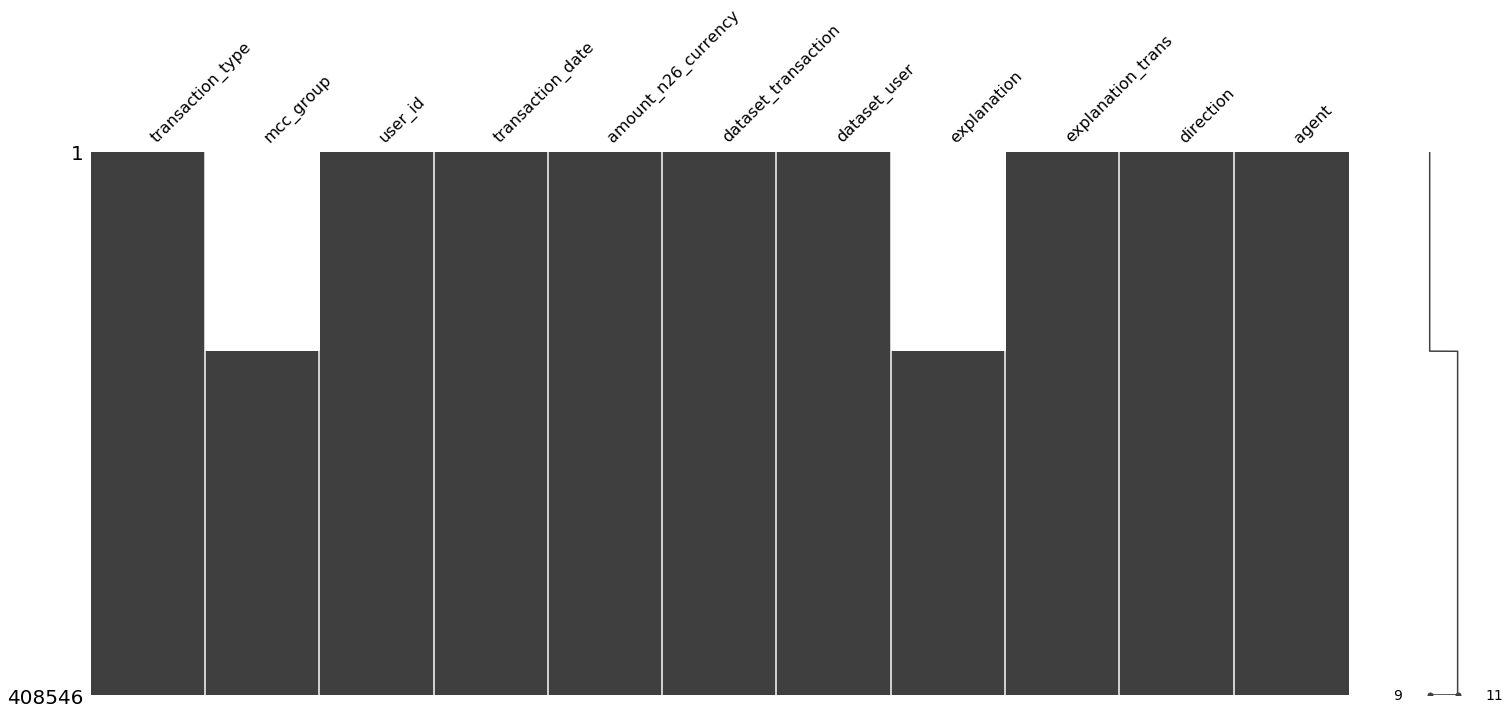

In [54]:
import missingno as msno
msno.matrix(df_merge_meta)

##### b. drop useless columns and replace `mcc_group` NA value to unknown treated as one of categories

In [8]:
drop_cols = ['transaction_type','mcc_group','dataset_transaction','dataset_user']
df_merge_meta = df_merge_meta.drop(drop_cols, axis=1)
df_merge_meta = df_merge_meta.rename(columns={'explanation':'mcc_group','explanation_trans':'trans_type'})
df_merge_meta['mcc_group'] = df_merge_meta['mcc_group'].fillna('Unknown')

##### c. aggragrated data by date and in/out

- transfrom to date format for plotting

In [9]:
df_merge_meta['transaction_date'] = pd.to_datetime(df_merge_meta['transaction_date'])
df_merge_meta['month'] = df_merge_meta['transaction_date'].dt.month

##### d. daily and monthly revenue and expenses

- The pattern of Expenses are following the revenue with periodical trends in each month.
- In general, the amount of expenses is higher than revenue in each month.

In [10]:
agg_date_inout = df_merge_meta.groupby(['transaction_date','direction'])['amount_n26_currency'].sum().reset_index()
agg_month_inout = df_merge_meta.groupby(['month','direction'])['amount_n26_currency'].sum().reset_index()

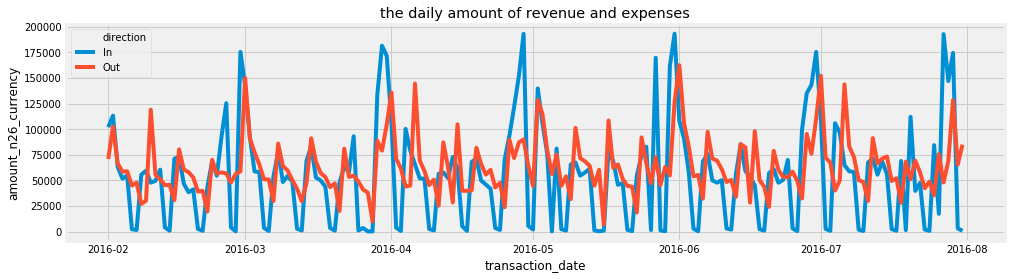

In [24]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.lineplot(
    x='transaction_date',
    y="amount_n26_currency",
    hue="direction",
    data=agg_date_inout,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the daily amount of revenue and expenses')
plt.show()

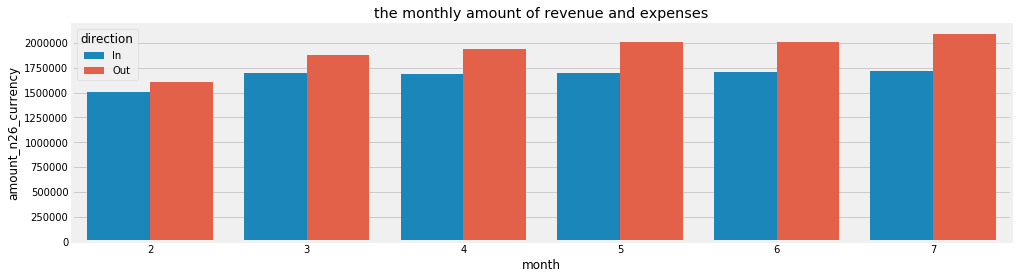

In [12]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.barplot(
    x='month',
    y="amount_n26_currency",
    hue="direction",
    data=agg_month_inout,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the monthly amount of revenue and expenses')
plt.show()

##### e. daily and monthly active users

- active users in expenses inidates higher than active users in revenues.

In [14]:
daily_active_user = df_merge_meta.groupby(['transaction_date','direction'])['user_id'].nunique().reset_index()
monthly_active_user = df_merge_meta.groupby(['month','direction'])['user_id'].nunique().reset_index()

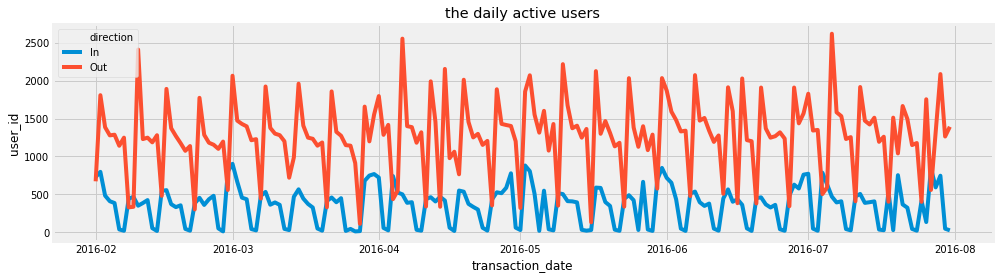

In [23]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.lineplot(
    x='transaction_date',
    y="user_id",
    hue="direction",
    data=daily_active_user,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the daily active users')
plt.show()

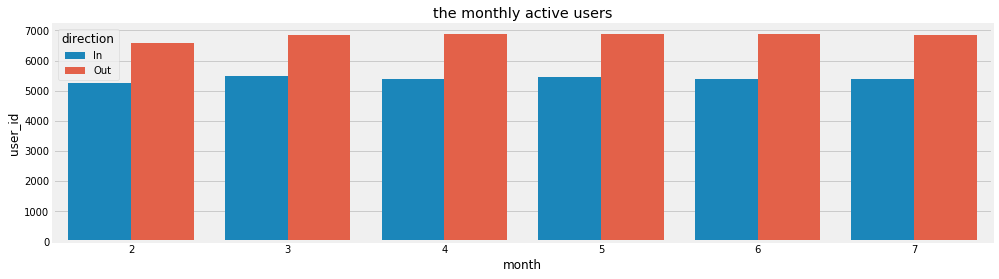

In [16]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.barplot(
    x='month',
    y="user_id",
    hue="direction",
    data=monthly_active_user,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the monthly active users')
plt.show()

##### f. the usage for mcc_group, in / out and transaction_type 

- Revenue is mainly from `Credit Transfer`, accounts for 94.3%
- Top 2 categories in expenses from mcc_group are `Unknown` and `ATM`.
- Top 2 categories in expenses from transaction_type are `Presentment` and `Debit Transfer`.

In [17]:
usage_mcc = df_merge_meta.groupby(
    ['direction','mcc_group']
).agg({'amount_n26_currency':'sum','user_id':'nunique'}).reset_index()
usage_trans = df_merge_meta.groupby(
    ['direction','trans_type']
).agg({'amount_n26_currency':'sum','user_id':'nunique'}).reset_index()

C:\Users\Chang_000\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


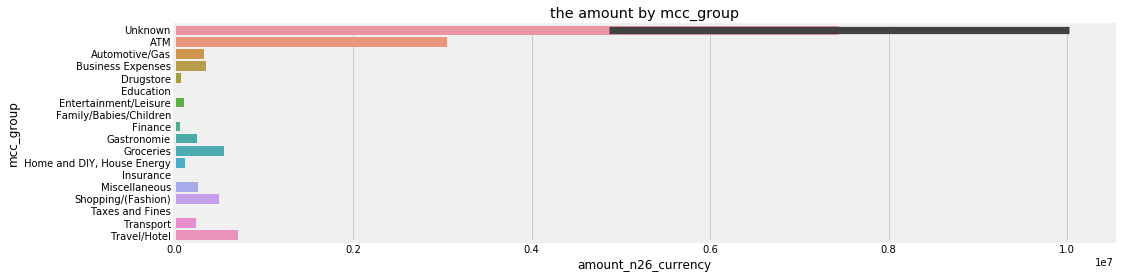

In [18]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.barplot(
    x='amount_n26_currency',
    y="mcc_group",
    #hue="trans_type",
    data=usage_mcc,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the amount by mcc_group')
plt.show()

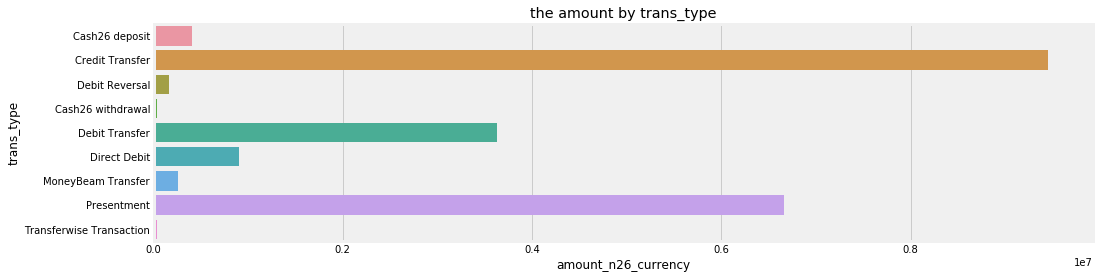

In [19]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.barplot(
    x='amount_n26_currency',
    y="trans_type",
    data=usage_trans,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the amount by trans_type')
plt.show()

##### g. the daily amount by transaction type

In [20]:
usage_trans_daily = df_merge_meta.groupby(
    ['direction','transaction_date','trans_type']
).agg({'amount_n26_currency':'sum','user_id':'nunique'}).reset_index()

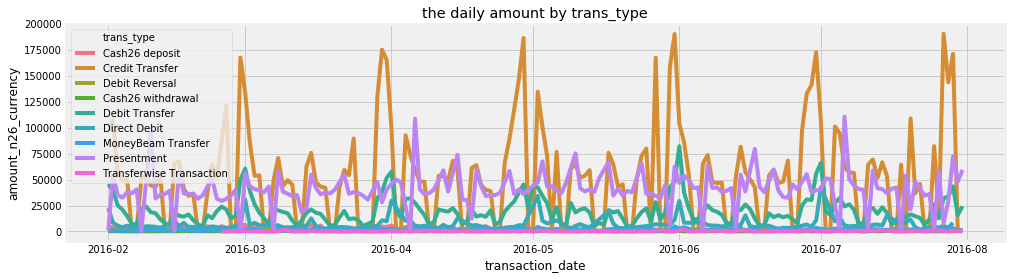

In [22]:
fig, ax = plt.subplots(figsize=(15,4))

ax = sns.lineplot(
    x='transaction_date',
    y="amount_n26_currency",
    hue="trans_type",
    data=usage_trans_daily,
    ax=ax
)

plt.xticks(rotation=0)
plt.title('the daily amount by trans_type')
plt.show()

## III. EDA for Time Series Forecasting

- Aggregrate by revenue / expense
- Decomposing time series for seeing treand and seasonality.
- ACF / PACF for checking stationary
- Plotting Rolling Statistics

In [25]:
df_daily_trans = df_merge_meta.groupby(
    ['transaction_date','direction']
)['amount_n26_currency'].sum().reset_index()

In [26]:
df_daily_rev = df_daily_trans[df_daily_trans['direction'] == 'In'].drop('direction', axis=1)
df_daily_exp = df_daily_trans[df_daily_trans['direction'] == 'Out'].drop('direction', axis=1)
y_rev = df_daily_rev.set_index('transaction_date')
y_exp = df_daily_exp.set_index('transaction_date')

##### Decomposing using statsmodel:

- We can use statsmodels to perform a decomposition of this time series.
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns.
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

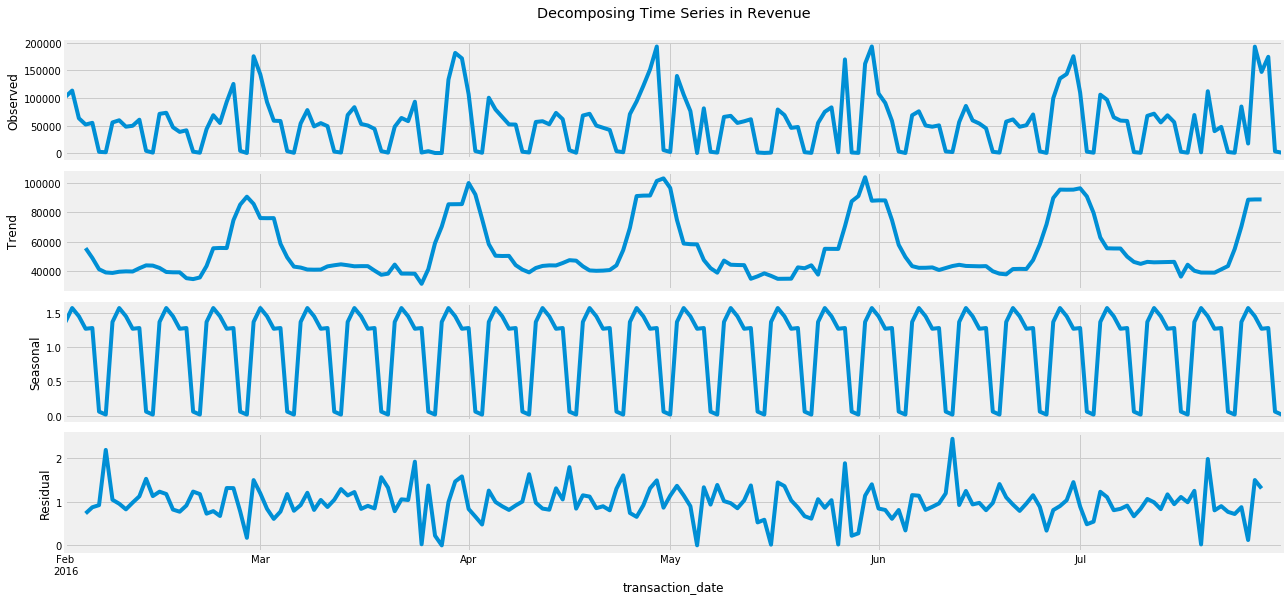

In [27]:
from pylab import rcParams

rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y_rev, model='multiplicative')
fig = decomposition.plot()
plt.title('Decomposing Time Series in Revenue', y=4.5)
plt.show()

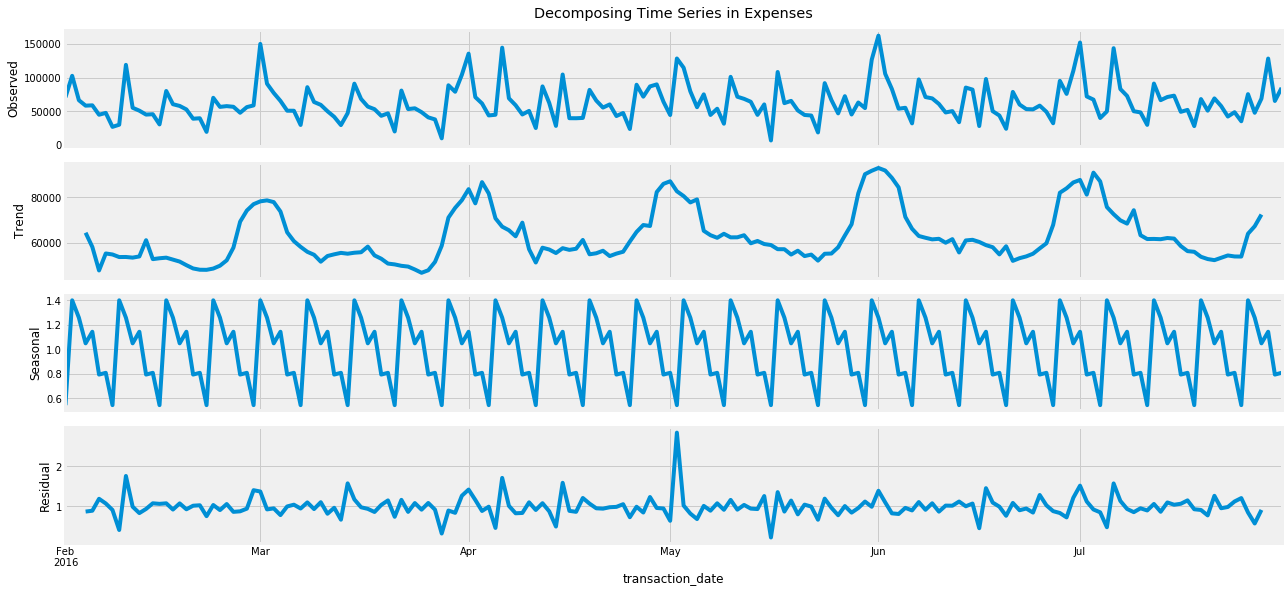

In [28]:
rcParams['figure.figsize'] = 18,8

decomposition = sm.tsa.seasonal_decompose(y_exp, model='multiplicative')
fig = decomposition.plot()
plt.title('Decomposing Time Series in Expenses', y=4.5)
plt.show()

##### Check Stationary - ACF / PACF

If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.

- The daily revenue data shows a stationary pattern as a quick drop-off in lag points after the first point.
- The daily expenses data also displays a stationary pattern as a quick drop-off in lag points after the first point.

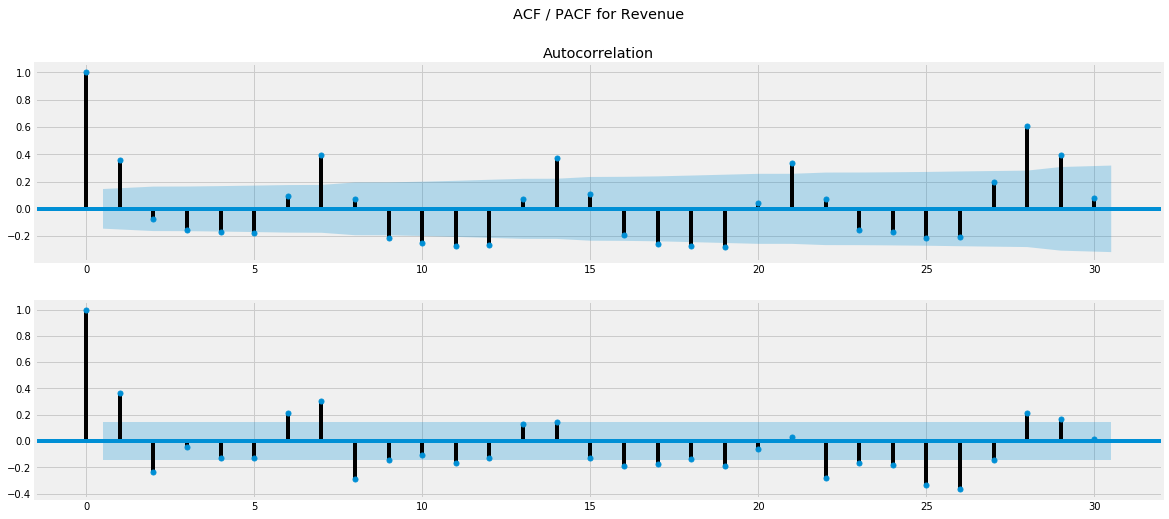

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(y_rev.amount_n26_currency, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(y_rev.amount_n26_currency, ax=plt.gca(), lags = 30)
plt.title('ACF / PACF for Revenue', y=2.4)
plt.show()

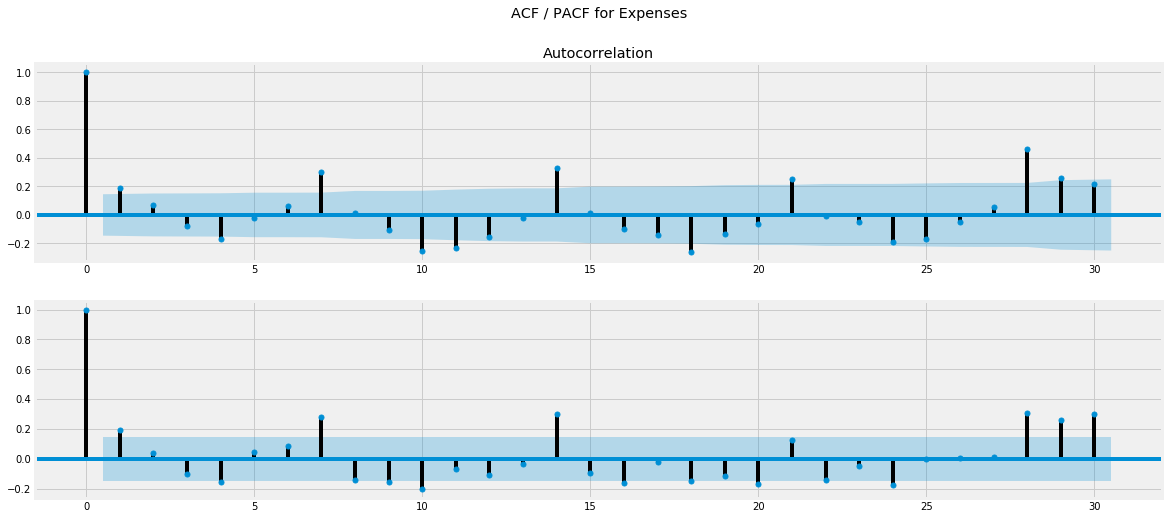

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(y_exp.amount_n26_currency, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(y_exp.amount_n26_currency, ax=plt.gca(), lags = 30)
plt.title('ACF / PACF for Expenses', y=2.4)
plt.show()

##### Check Stationary - Plotting Rolling Statistics
- The plot in revenue data indicates the `rolling mean` and `standard deviation` are quite constant with respect to time trend.
- Same as the plot in expenses data indicates the `rolling mean` and `standard deviation` are quite constant with respect to time trend as well.

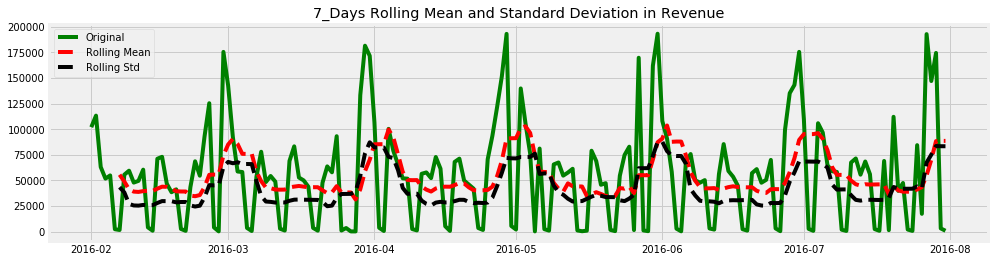

In [31]:
win_days = 7

rolmean = y_rev.rolling(window=win_days).mean()
rolstd = y_rev.rolling(window=win_days).std()

fig, ax = plt.subplots(figsize=(15,4))
orig = plt.plot(y_rev, color='g',label='Original')
mean = plt.plot(rolmean, color='r', label='Rolling Mean', linestyle='dashed')
std = plt.plot(rolstd, color='black', label = 'Rolling Std', linestyle='dashed')

plt.legend(loc='best')
plt.title(str(win_days) + '_Days Rolling Mean and Standard Deviation in Revenue')
plt.show(block=False)

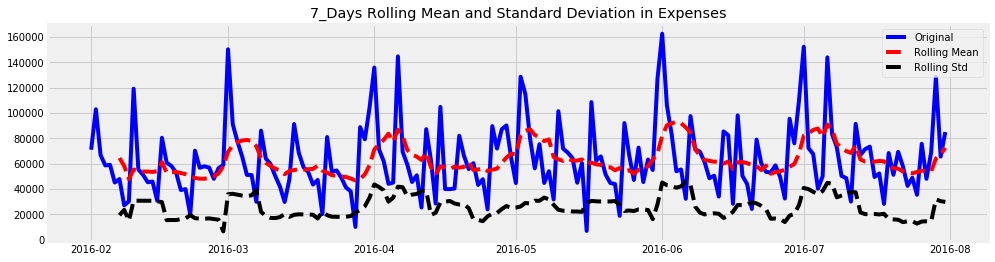

In [32]:
rolmean = y_exp.rolling(window=win_days).mean()
rolstd = y_exp.rolling(window=win_days).std()

fig, ax = plt.subplots(figsize=(15,4))
orig = plt.plot(y_exp, color='b',label='Original')
mean = plt.plot(rolmean, color='r', label='Rolling Mean', linestyle='dashed')
std = plt.plot(rolstd, color='black', label = 'Rolling Std', linestyle='dashed')

plt.legend(loc='best')
plt.title(str(win_days) + '_Days Rolling Mean and Standard Deviation in Expenses')
plt.show(block=False)

##### Check Stationary - Augmented Dickey-Fuller Test

- DF Test for Revenue data shows it is stationary.
- DF Test for Expenses data displays it is stationary as well.

In [33]:
from statsmodels.tsa.stattools import adfuller

In [34]:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(y_rev.amount_n26_currency, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.900717
p-value                          0.002030
#Lags Used                      14.000000
Number of Observations Used    167.000000
Critical Value (5%)             -2.879008
Critical Value (1%)             -3.470126
Critical Value (10%)            -2.576083
dtype: float64


In [35]:
print ('Results of Dickey-Fuller Test:')

dftest = adfuller(y_exp.amount_n26_currency, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.343992
p-value                          0.013023
#Lags Used                      13.000000
Number of Observations Used    168.000000
Critical Value (5%)             -2.878903
Critical Value (1%)             -3.469886
Critical Value (10%)            -2.576027
dtype: float64


## IV. Imporve Stationary and Seasonality for Time Series Data 

### a. Log Scale Tranform

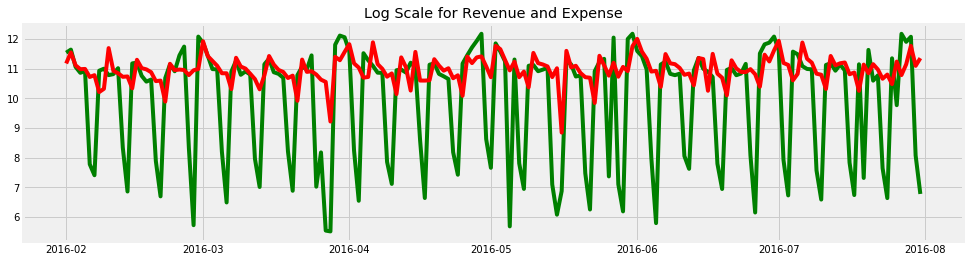

In [36]:
ts_rev_log = np.log(y_rev)
ts_exp_log = np.log(y_exp)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ts_rev_log, color = 'g')
plt.plot(ts_exp_log, color = 'r')
plt.title('Log Scale for Revenue and Expense')
plt.show()

### b. Remove Trend by Moving Average (MA)

In [37]:
win_days_rev = 7
win_days_exp = 14

moving_avg_rev = ts_rev_log.rolling(window=win_days_rev).mean()
moving_avg_exp = ts_exp_log.rolling(window=win_days_exp).mean()

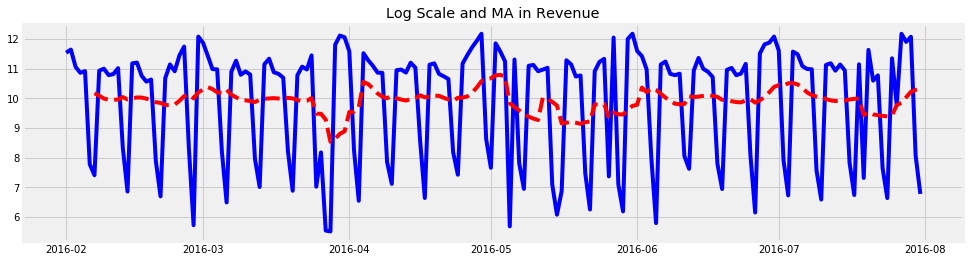

In [38]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ts_rev_log,color='b')
plt.plot(moving_avg_rev, color='r', linestyle='dashed')
plt.title('Log Scale and MA in Revenue')
plt.show()

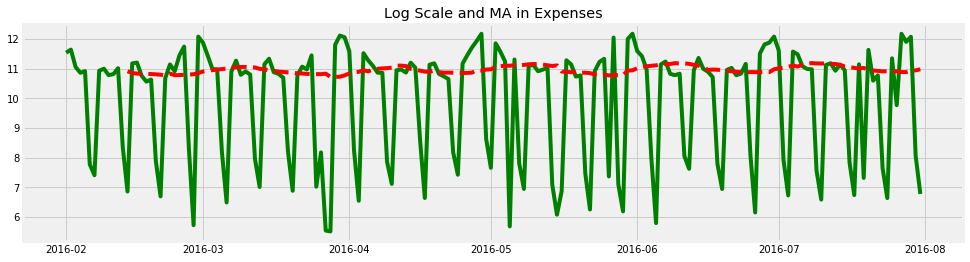

In [39]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ts_rev_log, color='g')
plt.plot(moving_avg_exp, color='r', linestyle='dashed')
plt.title('Log Scale and MA in Expenses')
plt.show()

In [40]:
ts_log_moving_avg_diff_rev = ts_rev_log.amount_n26_currency - moving_avg_rev.amount_n26_currency
ts_log_moving_avg_diff_exp = ts_exp_log.amount_n26_currency - moving_avg_exp.amount_n26_currency

#### 1. Log + MA in Revenue

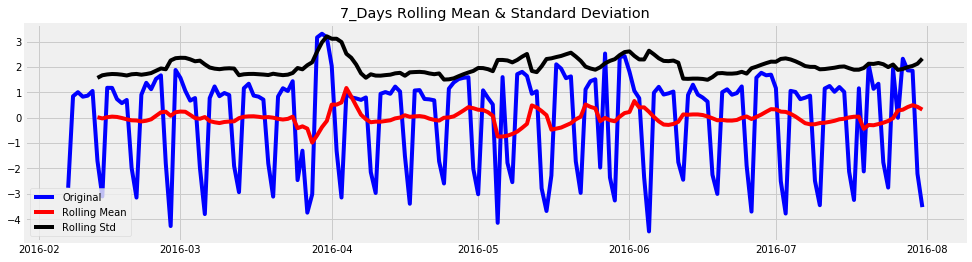

Results of Dickey-Fuller Test:
Test Statistic                  -3.771631
p-value                          0.003211
#Lags Used                      13.000000
Number of Observations Used    162.000000
Critical Value (5%)             -2.879552
Critical Value (1%)             -3.471374
Critical Value (10%)            -2.576373
dtype: float64


In [41]:
ts_log_moving_avg_diff_rev.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff_rev, win_days_rev)

#### 2. Log + MA in Expenses

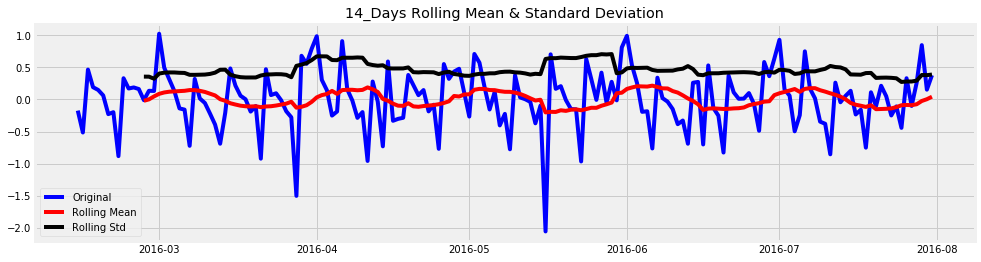

Results of Dickey-Fuller Test:
Test Statistic                  -3.870229
p-value                          0.002265
#Lags Used                      13.000000
Number of Observations Used    155.000000
Critical Value (5%)             -2.880374
Critical Value (1%)             -3.473259
Critical Value (10%)            -2.576812
dtype: float64


In [42]:
ts_log_moving_avg_diff_exp.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff_exp, win_days_exp)

### c. Exponentially Weighted Moving Average (EWMA)

- We like to compare another approch for removing seasonality is `EWMA`.
- The data in revenue shows `EWMA` gives a better stationality compared with `MA`.
- However, The data in expenses indicates `MA` performances much better than compared with `EWMA`.

In [43]:
expwighted_avg_rev = ts_rev_log.ewm(span=win_days_rev, adjust=False).mean()
expwighted_avg_exp = ts_rev_log.ewm(span=win_days_exp, adjust=False).mean()

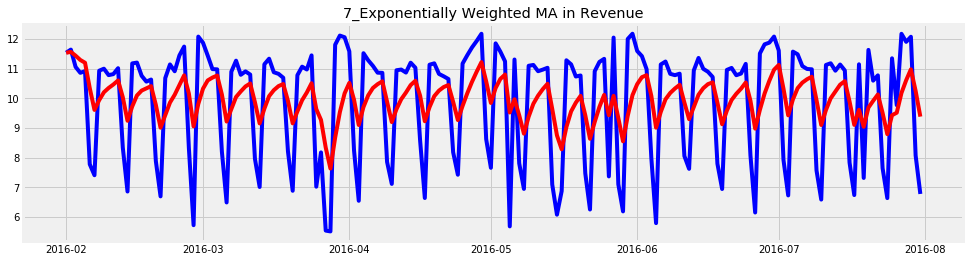

In [47]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ts_rev_log, color='b')
plt.plot(expwighted_avg_rev, color='r')
plt.title(str(win_days) + '_Exponentially Weighted MA in Revenue')
plt.show()

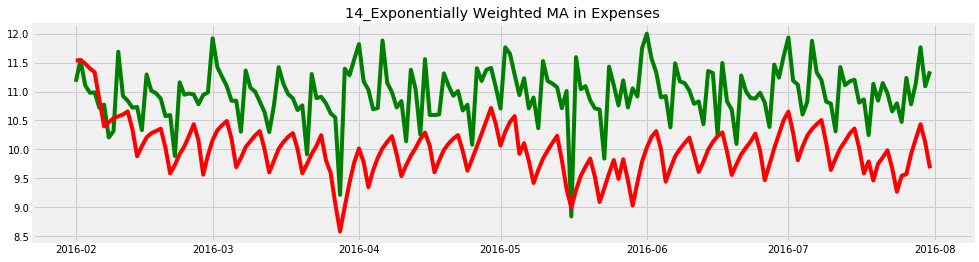

In [46]:
fig, ax = plt.subplots(figsize=(15,4))
plt.plot(ts_exp_log, color='g')
plt.plot(expwighted_avg_exp, color='r')
plt.title(str(win_days_exp) + '_Exponentially Weighted MA in Expenses')
plt.show()

#### 1. Log + EWMA in Revenue

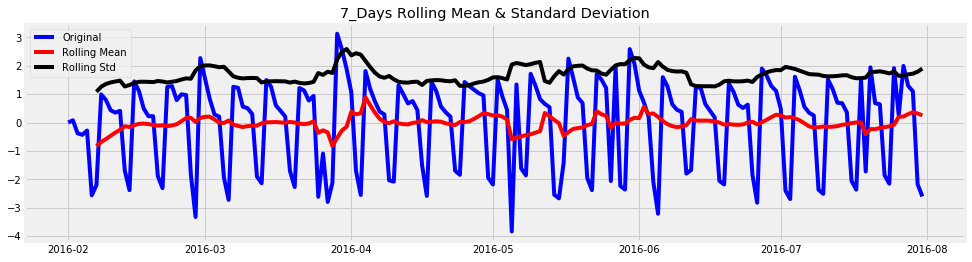

Results of Dickey-Fuller Test:
Test Statistic                  -4.460372
p-value                          0.000232
#Lags Used                      13.000000
Number of Observations Used    168.000000
Critical Value (5%)             -2.878903
Critical Value (1%)             -3.469886
Critical Value (10%)            -2.576027
dtype: float64


In [48]:
ts_log_ewma_diff_rev = ts_rev_log.amount_n26_currency - expwighted_avg_rev.amount_n26_currency
test_stationarity(ts_log_ewma_diff_rev, win_days_rev)

#### 2. Log + EWMA in Expenses

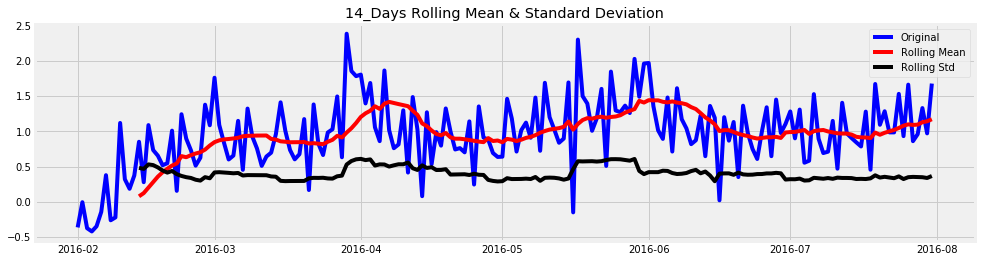

Results of Dickey-Fuller Test:
Test Statistic                  -3.186707
p-value                          0.020767
#Lags Used                      13.000000
Number of Observations Used    168.000000
Critical Value (5%)             -2.878903
Critical Value (1%)             -3.469886
Critical Value (10%)            -2.576027
dtype: float64


In [49]:
ts_log_ewma_diff_exp = ts_exp_log.amount_n26_currency - expwighted_avg_exp.amount_n26_currency
test_stationarity(ts_log_ewma_diff_exp, win_days_exp)

In [50]:
ts_log_ewma_diff_exp

transaction_date
2016-02-01   -0.362927
2016-02-02   -0.005830
2016-02-03   -0.373945
2016-02-04   -0.419559
2016-02-05   -0.347145
                ...   
2016-07-27    0.859207
2016-07-28    0.958465
2016-07-29    1.327934
2016-07-30    0.969950
2016-07-31    1.675377
Name: amount_n26_currency, Length: 182, dtype: float64

## V. Forecasting for Revenue and Expenses 

- EDA results show the data from both revenue and expenses are quite stationary.
- In this case, we will apply `Auto ARIMA`, `Auto SARIMA` and `Auto Tuned SARIMA` on the train set.

### a. Create Training and Validating Set

In [51]:
y_rev_train = ts_rev_log.iloc[0:151]
y_rev_val = ts_rev_log.iloc[151:]
y_exp_train = ts_exp_log.iloc[0:151]
y_exp_val = ts_exp_log.iloc[151:]

### b1. Auto ARIMA for Revenue 

In [52]:
model = auto_arima(y_rev_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_rev_train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=605.819, BIC=623.923, Fit time=0.703 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=629.575, BIC=635.610, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=621.058, BIC=630.110, Fit time=0.146 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=611.054, BIC=620.106, Fit time=0.080 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=612.628, BIC=627.715, Fit time=0.595 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=597.964, BIC=619.085, Fit time=0.866 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=587.957, BIC=606.060, Fit time=0.804 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=603.230, BIC=615.300, Fit time=0.094 seconds
Fit ARIMA: order=(4, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=592.379, BIC=616.518, Fit time=0.998 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

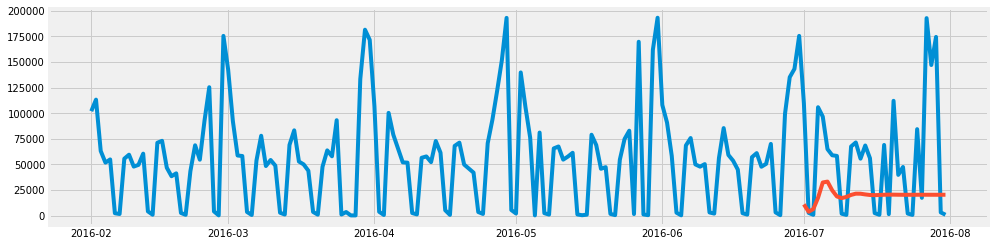

In [53]:
forecast = model.predict(n_periods=len(y_rev_val))
forecast = pd.DataFrame(forecast, index = y_rev_val.index, columns=['Prediction'])
forecast = np.exp(forecast)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(y_rev.amount_n26_currency, label='Train')
plt.plot(forecast, label='Prediction')
plt.title('Auto ARIMA Forecasting for Revenue')
plt.show()

In [54]:
evaluate_forecast(y_rev_val, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-1.082897e+08,19785.474814,20395.609608,4.205380e+08,55.992174,NaN,20507.022729


### b2. Auto SARIMA for Revenue

In [55]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(
    y_rev_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=5, stepwise=True
)
model.fit(y_rev_train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 5); AIC=611.713, BIC=635.851, Fit time=1.600 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 5); AIC=629.575, BIC=635.610, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 5); AIC=608.891, BIC=620.960, Fit time=0.515 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 5); AIC=597.836, BIC=609.905, Fit time=0.128 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 5); AIC=598.159, BIC=613.246, Fit time=1.232 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 5); AIC=611.054, BIC=620.106, Fit time=0.078 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 5); AIC=597.672, BIC=612.758, Fit time=0.249 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 5); AIC=591.022, BIC=609.125, Fit time=1.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 2, 5); AIC=600.457, BIC=615.543, Fit time=0.537 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 2, 5);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 2, 5), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [56]:
start_index = y_rev_val.index.min()
end_index = y_rev_val.index.max()
pred = model.predict()
pred = model.predict(n_periods=len(y_rev_val))
pred = pd.DataFrame(y_rev_val, index = y_rev_val.index, columns=['Prediction'])

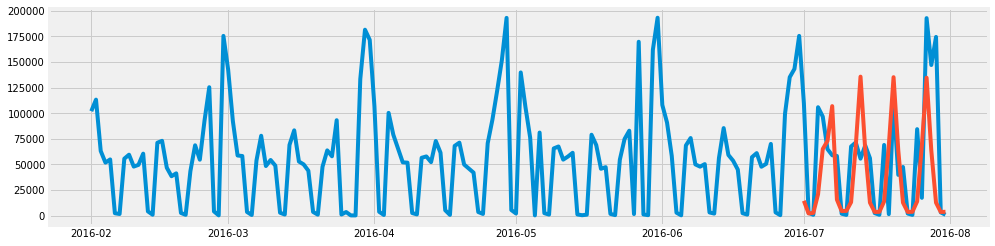

In [57]:
forecast_s = model.predict(n_periods=len(y_rev_val))
forecast_s = pd.DataFrame(forecast_s, index = y_rev_val.index,columns=['Prediction'])
forecast_s = np.exp(forecast_s)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(y_rev.amount_n26_currency, label='Train')
plt.plot(forecast_s, label='Prediction')
plt.title('Auto SARIMA Forecasting for Revenue')
plt.show()

In [58]:
evaluate_forecast(y_rev_val, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-1.082897e+08,19785.474814,20395.609608,4.205380e+08,55.992174,NaN,20507.022729


### b3. SARIMA Tuning for Revenue

In [134]:
def sarima_tuning(data, range_max, diff_times):
    
    p = d = q = range(0, range_max)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], diff_times) for x in list(itertools.product(p, d, q))]
    
    min_aic = 999999999

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(data,
                                                  order=param,
                                                  seasonal_order=param_seasonal,
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False
                                                 )

                results = model.fit()
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

                #find the lowest AIC
                if results.aic < min_aic:
                    min_aic = results.aic
                    min_aic_model = results
    
            except:
                continue
                
    return min_aic_model

In [135]:
min_aic_model_rev = sarima_tuning(y_rev_train, 3, 6)

C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1122.3174963389965


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:935.4709679305729


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 2, 6)12 - AIC:811.8915072729369
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:660.0417694609553


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:600.5063933123522
ARIMA(0, 0, 0)x(0, 1, 2, 6)12 - AIC:561.9440466094563
ARIMA(0, 0, 0)x(0, 2, 0, 6)12 - AIC:751.9538559457972


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 2, 1, 6)12 - AIC:629.8301738170277


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 2, 2, 6)12 - AIC:588.0983410417336
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:666.4394486979126


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:627.3191275230516


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 2, 6)12 - AIC:589.1250880460756
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:638.1912891642621


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:596.7937170049299


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 2, 6)12 - AIC:562.9700187206373
ARIMA(0, 0, 0)x(1, 2, 0, 6)12 - AIC:699.2228035600938


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 2, 1, 6)12 - AIC:631.7608665270653


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 2, 2, 6)12 - AIC:586.4210976360089
ARIMA(0, 0, 0)x(2, 0, 0, 6)12 - AIC:638.7905726017387


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 6)12 - AIC:603.1080221097066


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 6)12 - AIC:590.3736151836708
ARIMA(0, 0, 0)x(2, 1, 0, 6)12 - AIC:601.5120533583508


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 1, 6)12 - AIC:562.8540549241828


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 2, 6)12 - AIC:549.8334891943891
ARIMA(0, 0, 0)x(2, 2, 0, 6)12 - AIC:644.1589107718822


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 1, 6)12 - AIC:600.748287671996


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 2, 6)12 - AIC:580.7042380188924
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:949.0980139419923


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:823.2408634470572


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 2, 6)12 - AIC:750.616706602699
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:658.001148964405


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:577.7984174332904


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 2, 6)12 - AIC:557.338345719094
ARIMA(0, 0, 1)x(0, 2, 0, 6)12 - AIC:746.9623625048926


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 2, 1, 6)12 - AIC:626.0348041491732


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 2, 2, 6)12 - AIC:565.5881067639658


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:669.0060122524188
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:606.4194678320184


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 2, 6)12 - AIC:581.8456282037957
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:636.5992225243419


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:581.6255023384927


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 2, 6)12 - AIC:556.254094844439
ARIMA(0, 0, 1)x(1, 2, 0, 6)12 - AIC:700.9139566061893


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 1, 6)12 - AIC:625.3816294307685


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 2, 6)12 - AIC:567.5875253817626


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 0, 6)12 - AIC:641.775871078959


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 6)12 - AIC:640.2444556310251
ARIMA(0, 0, 1)x(2, 0, 2, 6)12 - AIC:580.7708337961901
ARIMA(0, 0, 1)x(2, 1, 0, 6)12 - AIC:596.0472461746832


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 1, 6)12 - AIC:560.7157745051802


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 2, 6)12 - AIC:545.8545684297305


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 0, 6)12 - AIC:643.3499660117959


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 1, 6)12 - AIC:595.609942119193


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 2, 6)12 - AIC:574.4639692045456
ARIMA(0, 0, 2)x(0, 0, 0, 6)12 - AIC:857.4200599290396


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 1, 6)12 - AIC:765.3533733392694


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 2, 6)12 - AIC:725.8919711724607
ARIMA(0, 0, 2)x(0, 1, 0, 6)12 - AIC:626.706623106604


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 1, 6)12 - AIC:566.6198832910127


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 2, 6)12 - AIC:539.5325544236939


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 2, 0, 6)12 - AIC:714.7853528375492


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 2, 1, 6)12 - AIC:600.0660379571261


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 2, 2, 6)12 - AIC:556.7166688239129


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 0, 6)12 - AIC:642.3556351715638


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 1, 6)12 - AIC:594.2946101087217


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 2, 6)12 - AIC:566.400688516858
ARIMA(0, 0, 2)x(1, 1, 0, 6)12 - AIC:610.7708608062496
ARIMA(0, 0, 2)x(1, 1, 1, 6)12 - AIC:565.7565662601747


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 1, 2, 6)12 - AIC:541.3200070689415


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 0, 6)12 - AIC:656.9612262064556


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 1, 6)12 - AIC:596.4726022431487


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 2, 6)12 - AIC:558.712767053538


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 0, 6)12 - AIC:612.5993949936787


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 6)12 - AIC:616.7421765476056


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 6)12 - AIC:568.4680726177332
ARIMA(0, 0, 2)x(2, 1, 0, 6)12 - AIC:586.5137156505587


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 1, 6)12 - AIC:556.0564348795048


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 2, 6)12 - AIC:532.5947154312295


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 0, 6)12 - AIC:623.4756928189288


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 1, 6)12 - AIC:585.3777988269366


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 2, 6)12 - AIC:557.731286188588
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:678.7126323853599
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:655.3082750058204


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 2, 6)12 - AIC:617.6874734216397
ARIMA(0, 1, 0)x(0, 1, 0, 6)12 - AIC:750.4459344086653


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 6)12 - AIC:648.0903459225614


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 2, 6)12 - AIC:623.8159014664743
ARIMA(0, 1, 0)x(0, 2, 0, 6)12 - AIC:853.7188116744112


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 2, 1, 6)12 - AIC:711.1767727577374


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 2, 2, 6)12 - AIC:627.3211149016628
ARIMA(0, 1, 0)x(1, 0, 0, 6)12 - AIC:661.0845593815296


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 6)12 - AIC:655.7199080106434


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 2, 6)12 - AIC:618.7853373877429
ARIMA(0, 1, 0)x(1, 1, 0, 6)12 - AIC:713.3634181145198


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 6)12 - AIC:650.0903175954115


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 6)12 - AIC:620.1789354768009
ARIMA(0, 1, 0)x(1, 2, 0, 6)12 - AIC:788.7559681777382


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 2, 1, 6)12 - AIC:703.8923850139985


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 2, 2, 6)12 - AIC:629.3208076743123
ARIMA(0, 1, 0)x(2, 0, 0, 6)12 - AIC:623.4026685007645
ARIMA(0, 1, 0)x(2, 0, 1, 6)12 - AIC:625.385419755933


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 0, 2, 6)12 - AIC:620.4464771061779
ARIMA(0, 1, 0)x(2, 1, 0, 6)12 - AIC:651.6609763066078


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 6)12 - AIC:621.1209222890218


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 2, 6)12 - AIC:617.5933830596067
ARIMA(0, 1, 0)x(2, 2, 0, 6)12 - AIC:707.4668073010383


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 1, 6)12 - AIC:648.4332603902858


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 2, 6)12 - AIC:636.6347481532481
ARIMA(0, 1, 1)x(0, 0, 0, 6)12 - AIC:623.7217452466965


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 6)12 - AIC:588.6487398882068


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 2, 6)12 - AIC:561.0579760982944


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 6)12 - AIC:660.0606863829635


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 6)12 - AIC:599.4266576295189


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 2, 6)12 - AIC:560.7158186121699
ARIMA(0, 1, 1)x(0, 2, 0, 6)12 - AIC:748.1630400967714


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 1, 6)12 - AIC:626.9830331997105


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 2, 6)12 - AIC:586.9865066730631


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 6)12 - AIC:603.6422817024325


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 6)12 - AIC:590.3660802722916


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 2, 6)12 - AIC:553.0388956880533


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 6)12 - AIC:641.5497718158813


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 6)12 - AIC:597.611063047234


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 6)12 - AIC:561.5102308276826


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 0, 6)12 - AIC:701.8686337734409


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 1, 6)12 - AIC:628.9142538111246


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 2, 6)12 - AIC:603.1162361630645


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 0, 6)12 - AIC:565.7099795135396


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 6)12 - AIC:550.8331246287619


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 2, 6)12 - AIC:539.2473693506008


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 6)12 - AIC:604.9139102583822


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 6)12 - AIC:570.53112344636


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 6)12 - AIC:550.905942828154


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 0, 6)12 - AIC:646.9572697793969


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 1, 6)12 - AIC:607.7157143301299


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 2, 6)12 - AIC:604.8269555114663
ARIMA(0, 1, 2)x(0, 0, 0, 6)12 - AIC:602.0384476869315


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 1, 6)12 - AIC:580.1570791924692


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 2, 6)12 - AIC:550.7310141570065
ARIMA(0, 1, 2)x(0, 1, 0, 6)12 - AIC:657.3949757536036


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 1, 6)12 - AIC:579.3856351784707


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 2, 6)12 - AIC:554.8969965268778


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 0, 6)12 - AIC:743.7906510566099


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 1, 6)12 - AIC:623.93649614538


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 2, 6)12 - AIC:565.8571088077758
ARIMA(0, 1, 2)x(1, 0, 0, 6)12 - AIC:593.6402980340331


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 1, 6)12 - AIC:580.5789211003976


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 2, 6)12 - AIC:547.8211994960726


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 0, 6)12 - AIC:639.4652822597316


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 6)12 - AIC:583.537563854101


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 6)12 - AIC:554.3478800179137


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 0, 6)12 - AIC:703.7129319168316


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 1, 6)12 - AIC:623.926965725422


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 2, 6)12 - AIC:571.0739259640391


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 0, 6)12 - AIC:563.076159891262


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 6)12 - AIC:552.807669344377


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 6)12 - AIC:513.0445844839535


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 6)12 - AIC:598.9637408595821


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 1, 6)12 - AIC:567.9807449445946


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 2, 6)12 - AIC:556.347314828136


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 0, 6)12 - AIC:645.8134607103966


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 1, 6)12 - AIC:602.1084937893236


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 2, 6)12 - AIC:574.2205704331706
ARIMA(0, 2, 0)x(0, 0, 0, 6)12 - AIC:798.4437318541711
ARIMA(0, 2, 0)x(0, 0, 1, 6)12 - AIC:763.9837172730452


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 0, 2, 6)12 - AIC:730.6421501383536
ARIMA(0, 2, 0)x(0, 1, 0, 6)12 - AIC:886.2333453573068


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 1, 1, 6)12 - AIC:756.171320608766


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 1, 2, 6)12 - AIC:724.6073090832869
ARIMA(0, 2, 0)x(0, 2, 0, 6)12 - AIC:993.5195586312252


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 2, 1, 6)12 - AIC:834.4496740101971


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 2, 2, 6)12 - AIC:725.1012687234652
ARIMA(0, 2, 0)x(1, 0, 0, 6)12 - AIC:772.3031878801253
ARIMA(0, 2, 0)x(1, 0, 1, 6)12 - AIC:764.9656922533941


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 0, 2, 6)12 - AIC:732.0300940590655
ARIMA(0, 2, 0)x(1, 1, 0, 6)12 - AIC:830.1383382104673


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 1, 6)12 - AIC:758.1657759937198


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 2, 6)12 - AIC:727.8736280781252
ARIMA(0, 2, 0)x(1, 2, 0, 6)12 - AIC:910.4864787294955


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 2, 1, 6)12 - AIC:813.258382583841


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 2, 2, 6)12 - AIC:731.1568933629205
ARIMA(0, 2, 0)x(2, 0, 0, 6)12 - AIC:733.248764340213


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 0, 1, 6)12 - AIC:734.7597174911482


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 0, 2, 6)12 - AIC:711.0693834789322
ARIMA(0, 2, 0)x(2, 1, 0, 6)12 - AIC:752.5495937898698


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 1, 6)12 - AIC:725.2935803232542


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 2, 6)12 - AIC:720.2314542767531
ARIMA(0, 2, 0)x(2, 2, 0, 6)12 - AIC:819.0181179482507


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 1, 6)12 - AIC:744.4720354879045


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 2, 6)12 - AIC:730.8201035948484
ARIMA(0, 2, 1)x(0, 0, 0, 6)12 - AIC:677.4865638929421


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 0, 1, 6)12 - AIC:654.6669850284767


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 0, 2, 6)12 - AIC:614.7598077348616
ARIMA(0, 2, 1)x(0, 1, 0, 6)12 - AIC:748.2713376540385


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 1, 1, 6)12 - AIC:646.960063590031


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 1, 2, 6)12 - AIC:621.2104234255837
ARIMA(0, 2, 1)x(0, 2, 0, 6)12 - AIC:848.8815964204526


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 1, 6)12 - AIC:706.5570587577593


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 2, 6)12 - AIC:626.2893252740562


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 0, 6)12 - AIC:661.1921662356956


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 1, 6)12 - AIC:653.6529996541944


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 2, 6)12 - AIC:616.2461950907856


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 0, 6)12 - AIC:716.1400775495696


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 1, 6)12 - AIC:648.960077805514


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 2, 6)12 - AIC:617.4999369556838


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 0, 6)12 - AIC:790.6798952441472


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 1, 6)12 - AIC:700.4507736354885


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 2, 6)12 - AIC:628.2892395728942


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 0, 6)12 - AIC:626.8433855590299


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 1, 6)12 - AIC:628.6961909868892


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 2, 6)12 - AIC:602.8524466311527


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 6)12 - AIC:654.6448740872606


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 1, 6)12 - AIC:628.3237755563479


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 2, 6)12 - AIC:615.322430366314


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 0, 6)12 - AIC:709.7316935273918


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 1, 6)12 - AIC:655.0406703068348


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 2, 6)12 - AIC:635.9059576465988


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 0, 6)12 - AIC:628.2204262142366


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 1, 6)12 - AIC:592.3307650028951


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 2, 6)12 - AIC:567.4082319333783


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 0, 6)12 - AIC:663.5475018280176


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 1, 6)12 - AIC:602.5415619649257


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 2, 6)12 - AIC:562.7746838232192


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 0, 6)12 - AIC:749.1611045774782


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 1, 6)12 - AIC:628.208462381825


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 2, 6)12 - AIC:591.8866088078628


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 0, 6)12 - AIC:613.6184544126472


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 1, 6)12 - AIC:593.9187474920079


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 2, 6)12 - AIC:559.595495170108


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 0, 6)12 - AIC:646.5250100264873


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 1, 6)12 - AIC:601.717968535459


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 2, 6)12 - AIC:563.452863152047


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 0, 6)12 - AIC:710.0285513844078


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 1, 6)12 - AIC:629.9703959069313


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 2, 6)12 - AIC:598.9164004472311


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 0, 6)12 - AIC:575.8365413160029


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 6)12 - AIC:562.6779302145004


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 2, 6)12 - AIC:569.7725188626428


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 0, 6)12 - AIC:614.1774432672509


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 1, 6)12 - AIC:581.89275238204


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 2, 6)12 - AIC:557.2783824365432
ARIMA(0, 2, 2)x(2, 2, 0, 6)12 - AIC:655.4954998630864


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 2, 1, 6)12 - AIC:615.6307684445003
ARIMA(0, 2, 2)x(2, 2, 2, 6)12 - AIC:598.9038970320904
ARIMA(1, 0, 0)x(0, 0, 0, 6)12 - AIC:682.3058824301484


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 6)12 - AIC:661.4388018042727


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 2, 6)12 - AIC:623.2110813318114
ARIMA(1, 0, 0)x(0, 1, 0, 6)12 - AIC:661.8366457185004


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 6)12 - AIC:592.843430431286


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 2, 6)12 - AIC:561.2917089052801
ARIMA(1, 0, 0)x(0, 2, 0, 6)12 - AIC:752.599345395834


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 1, 6)12 - AIC:631.4863312399141


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 2, 6)12 - AIC:579.8654581961014
ARIMA(1, 0, 0)x(1, 0, 0, 6)12 - AIC:661.9304023623803


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 6)12 - AIC:619.2160056867208


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 2, 6)12 - AIC:588.8078606783258
ARIMA(1, 0, 0)x(1, 1, 0, 6)12 - AIC:635.4778234985716


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 6)12 - AIC:594.357740252028


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 2, 6)12 - AIC:561.2212370925919
ARIMA(1, 0, 0)x(1, 2, 0, 6)12 - AIC:695.6720691947149


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 1, 6)12 - AIC:633.1698585615738


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 2, 6)12 - AIC:583.9298497460721


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 0, 6)12 - AIC:624.5617710874991


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 6)12 - AIC:626.5273502332736


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 6)12 - AIC:626.3901266065338
ARIMA(1, 0, 0)x(2, 1, 0, 6)12 - AIC:594.5743382026205


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 1, 6)12 - AIC:558.4206638715804


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 2, 6)12 - AIC:551.7027148785487


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 0, 6)12 - AIC:639.900771334196


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 1, 6)12 - AIC:593.4392398588683


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 2, 6)12 - AIC:580.5948892538881


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 6)12 - AIC:629.6106089738055
ARIMA(1, 0, 1)x(0, 0, 1, 6)12 - AIC:594.5300789203493


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 2, 6)12 - AIC:569.2794516781377
ARIMA(1, 0, 1)x(0, 1, 0, 6)12 - AIC:639.4358238368208


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 6)12 - AIC:577.6103112941606


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 2, 6)12 - AIC:552.3670849848148


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 2, 0, 6)12 - AIC:726.2201245939677


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 2, 1, 6)12 - AIC:613.8599057495658


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 2, 2, 6)12 - AIC:566.3969924861132


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 6)12 - AIC:605.6027433655836


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 6)12 - AIC:606.4791218580715


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 2, 6)12 - AIC:580.3935811786971
ARIMA(1, 0, 1)x(1, 1, 0, 6)12 - AIC:616.5806283876084


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 6)12 - AIC:579.0663646151293


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 6)12 - AIC:553.1201279585573


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 6)12 - AIC:674.2560712713632


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 1, 6)12 - AIC:612.9288993542507


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 2, 6)12 - AIC:568.3957005078856


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 6)12 - AIC:567.6885291752728


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 6)12 - AIC:552.9136352767613


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 6)12 - AIC:551.7720818361895
ARIMA(1, 0, 1)x(2, 1, 0, 6)12 - AIC:586.0737602224322


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 6)12 - AIC:556.3776832264114


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 2, 6)12 - AIC:546.4953013849126


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 0, 6)12 - AIC:624.2839572521448


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 1, 6)12 - AIC:587.849242909083


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 2, 6)12 - AIC:573.8628228137783


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 0, 6)12 - AIC:607.4781166672927


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 1, 6)12 - AIC:585.6683800107589


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 6)12 - AIC:556.2690381804276


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 0, 6)12 - AIC:627.6810282772503


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 6)12 - AIC:558.8373236988438


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 2, 6)12 - AIC:535.5024767168139


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 0, 6)12 - AIC:719.7774014349321


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 1, 6)12 - AIC:601.6957126103498


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 2, 6)12 - AIC:549.4934207902721


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 0, 6)12 - AIC:595.603724983802


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 6)12 - AIC:590.7511339148682


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 6)12 - AIC:555.6326942877909
ARIMA(1, 0, 2)x(1, 1, 0, 6)12 - AIC:605.2267657453142


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 6)12 - AIC:561.2577891463986


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 6)12 - AIC:536.370197349047


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 6)12 - AIC:653.152375791755


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 1, 6)12 - AIC:596.0568355138748


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 2, 6)12 - AIC:552.044283497034


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 6)12 - AIC:565.0542442118222


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 6)12 - AIC:554.7818428829664


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 6)12 - AIC:549.2694145020549
ARIMA(1, 0, 2)x(2, 1, 0, 6)12 - AIC:576.4019548487896


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 6)12 - AIC:547.3431684172806


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 6)12 - AIC:533.3182604337334


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 0, 6)12 - AIC:620.9271206564662


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 1, 6)12 - AIC:581.187668791625


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 2, 2, 6)12 - AIC:556.5092571102281
ARIMA(1, 1, 0)x(0, 0, 0, 6)12 - AIC:677.3055993430237
ARIMA(1, 1, 0)x(0, 0, 1, 6)12 - AIC:651.7063002453235


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 2, 6)12 - AIC:610.7660675339878
ARIMA(1, 1, 0)x(0, 1, 0, 6)12 - AIC:735.1159319758576


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 6)12 - AIC:647.07817370405


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 2, 6)12 - AIC:619.3310061771172
ARIMA(1, 1, 0)x(0, 2, 0, 6)12 - AIC:823.2251124159922


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 2, 1, 6)12 - AIC:697.1052188653533


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 2, 2, 6)12 - AIC:629.309203359869
ARIMA(1, 1, 0)x(1, 0, 0, 6)12 - AIC:653.334362021736
ARIMA(1, 1, 0)x(1, 0, 1, 6)12 - AIC:650.2316975537608


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 2, 6)12 - AIC:608.2853109119842
ARIMA(1, 1, 0)x(1, 1, 0, 6)12 - AIC:700.6450616383884


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 6)12 - AIC:651.292249931111


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 6)12 - AIC:617.0593655588498
ARIMA(1, 1, 0)x(1, 2, 0, 6)12 - AIC:770.0232240181832


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 1, 6)12 - AIC:697.2224533423869


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 2, 6)12 - AIC:629.8105564471265
ARIMA(1, 1, 0)x(2, 0, 0, 6)12 - AIC:612.7566763194577


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 6)12 - AIC:608.5283153780358


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 2, 6)12 - AIC:606.9265359093656
ARIMA(1, 1, 0)x(2, 1, 0, 6)12 - AIC:643.0862300128273


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 6)12 - AIC:611.0192575055991


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 6)12 - AIC:612.178849271176


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 0, 6)12 - AIC:688.3854175450755


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 1, 6)12 - AIC:639.501471317438


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 2, 6)12 - AIC:630.7546663884461
ARIMA(1, 1, 1)x(0, 0, 0, 6)12 - AIC:615.3410707645911


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 6)12 - AIC:587.9050185093229


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 2, 6)12 - AIC:555.5426410521065
ARIMA(1, 1, 1)x(0, 1, 0, 6)12 - AIC:661.8171914217294


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 6)12 - AIC:591.5591713430072


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 2, 6)12 - AIC:560.1832257144026


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 0, 6)12 - AIC:749.0793758338632


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 1, 6)12 - AIC:628.5752414309597


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 2, 6)12 - AIC:579.4956696372885


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 6)12 - AIC:595.4926228438331


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 6)12 - AIC:588.9052804371942


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 2, 6)12 - AIC:551.5526920526595


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 6)12 - AIC:636.2073485498288


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 6)12 - AIC:594.3894476915251


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 6)12 - AIC:559.6109390390206


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 0, 6)12 - AIC:698.8752062710561


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 1, 6)12 - AIC:631.3912990434079


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 2, 6)12 - AIC:604.8789803062735


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 0, 6)12 - AIC:561.9783941904503


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 6)12 - AIC:546.4330092764549


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 6)12 - AIC:517.3730107912111


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 6)12 - AIC:596.933058822111


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 6)12 - AIC:565.2245415496424


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 2, 6)12 - AIC:552.8868726014072


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 0, 6)12 - AIC:641.6940863149114


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 1, 6)12 - AIC:599.2445762306536


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 2, 6)12 - AIC:582.7089696738959
ARIMA(1, 1, 2)x(0, 0, 0, 6)12 - AIC:601.5758434554


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 1, 6)12 - AIC:575.0410693125935


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 2, 6)12 - AIC:551.0838497671464


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 0, 6)12 - AIC:637.8473208173336


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 6)12 - AIC:579.4084266835714


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 2, 6)12 - AIC:549.7549882939286


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 0, 6)12 - AIC:728.5620131741596


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 1, 6)12 - AIC:610.4985869841319


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 2, 6)12 - AIC:566.5105052092978


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 0, 6)12 - AIC:585.7894224317695


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 1, 6)12 - AIC:576.7285687733602


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 2, 6)12 - AIC:545.7586844505929


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 0, 6)12 - AIC:618.3725268506236


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 6)12 - AIC:581.5060849056017


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 6)12 - AIC:550.6910164003921


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 6)12 - AIC:682.3970490647564


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 1, 6)12 - AIC:611.9445667515054


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 2, 6)12 - AIC:568.509083631615


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 0, 6)12 - AIC:560.7452526518535


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 6)12 - AIC:548.4151156210803


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 6)12 - AIC:516.513896247254


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 6)12 - AIC:588.2107727035238


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 6)12 - AIC:562.762112012215


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 6)12 - AIC:552.6907423885903


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 0, 6)12 - AIC:625.5410782048899


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 1, 6)12 - AIC:593.3015524398554


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 2, 6)12 - AIC:573.8126609214967
ARIMA(1, 2, 0)x(0, 0, 0, 6)12 - AIC:771.4464177724878
ARIMA(1, 2, 0)x(0, 0, 1, 6)12 - AIC:743.0883641850548


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 0, 2, 6)12 - AIC:692.3288472167521
ARIMA(1, 2, 0)x(0, 1, 0, 6)12 - AIC:844.2810682257418


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 1, 1, 6)12 - AIC:731.444713901454


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 1, 2, 6)12 - AIC:704.7492479029362
ARIMA(1, 2, 0)x(0, 2, 0, 6)12 - AIC:936.7086837534519


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 2, 1, 6)12 - AIC:794.4980849478846


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 2, 2, 6)12 - AIC:703.5740029128667
ARIMA(1, 2, 0)x(1, 0, 0, 6)12 - AIC:744.0541870823615


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 0, 1, 6)12 - AIC:743.500548940059


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 0, 2, 6)12 - AIC:694.1877170333116
ARIMA(1, 2, 0)x(1, 1, 0, 6)12 - AIC:797.6381588745523


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 1, 6)12 - AIC:733.4446436332032


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 2, 6)12 - AIC:702.0874734122074
ARIMA(1, 2, 0)x(1, 2, 0, 6)12 - AIC:873.5034540633815


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 1, 6)12 - AIC:789.0972275486545


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 2, 6)12 - AIC:705.5738246376704
ARIMA(1, 2, 0)x(2, 0, 0, 6)12 - AIC:689.9518535700378


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 6)12 - AIC:690.1384094460911


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 2, 6)12 - AIC:666.2766443233436


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 0, 6)12 - AIC:707.4518259739182


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 1, 6)12 - AIC:683.9055176283064


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 2, 6)12 - AIC:682.2038035612686


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 0, 6)12 - AIC:763.418336364142


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 1, 6)12 - AIC:700.7096034730317


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 2, 6)12 - AIC:700.3832644409924
ARIMA(1, 2, 1)x(0, 0, 0, 6)12 - AIC:676.5572658922581


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 0, 1, 6)12 - AIC:650.8203242610034


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 0, 2, 6)12 - AIC:608.3200526260691
ARIMA(1, 2, 1)x(0, 1, 0, 6)12 - AIC:733.3091537437224


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 1, 6)12 - AIC:646.5554237058589


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 2, 6)12 - AIC:615.9634310729291


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 0, 6)12 - AIC:819.2957476088886


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 1, 6)12 - AIC:693.3376404184809


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 2, 6)12 - AIC:626.3882855067401


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 0, 6)12 - AIC:657.150215068446


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 1, 6)12 - AIC:648.3168505083501


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 2, 6)12 - AIC:606.9305310170378


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 0, 6)12 - AIC:701.8559194936495


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 1, 6)12 - AIC:648.5548180251242


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 2, 6)12 - AIC:613.9884177026752


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 0, 6)12 - AIC:770.4562607104315


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 1, 6)12 - AIC:694.6295491456697


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 2, 6)12 - AIC:662.8079964241876


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 0, 6)12 - AIC:616.17000661459


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 1, 6)12 - AIC:613.8124764972117


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 2, 6)12 - AIC:602.4883148221145


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 6)12 - AIC:645.6366551231747


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 1, 6)12 - AIC:616.2593592525302


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 2, 6)12 - AIC:610.528525710456


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 0, 6)12 - AIC:690.4561460235893


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 1, 6)12 - AIC:645.8418112516705


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 2, 6)12 - AIC:630.206355052807
ARIMA(1, 2, 2)x(0, 0, 0, 6)12 - AIC:675.9000474179127


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 1, 6)12 - AIC:653.3159091978256


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 2, 6)12 - AIC:561.4043179513914


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 0, 6)12 - AIC:665.2033331789469


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 1, 6)12 - AIC:594.0210020472502


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 2, 6)12 - AIC:561.6139912342436


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 0, 6)12 - AIC:750.2576723771045


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 1, 6)12 - AIC:629.6195478497364


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 2, 6)12 - AIC:577.2073130282926


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 0, 6)12 - AIC:659.7801024272678


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 1, 6)12 - AIC:651.0338371705952


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 2, 6)12 - AIC:557.8612837303153


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 0, 6)12 - AIC:643.183685466139


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 1, 6)12 - AIC:599.1223251578949


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 2, 6)12 - AIC:560.7804856382379


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 6)12 - AIC:705.0032373667229


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 1, 6)12 - AIC:631.3686379632123


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 2, 6)12 - AIC:600.2631386748526


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 6)12 - AIC:569.017573559441


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 6)12 - AIC:556.82331500804
ARIMA(1, 2, 2)x(2, 0, 2, 6)12 - AIC:601.7579770087477


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 6)12 - AIC:604.5780184994586


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 1, 6)12 - AIC:574.8200371637079


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 2, 6)12 - AIC:557.6973020386927
ARIMA(1, 2, 2)x(2, 2, 0, 6)12 - AIC:669.9818158143005


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 1, 6)12 - AIC:614.4970973012539


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 2, 6)12 - AIC:593.8399921924511
ARIMA(2, 0, 0)x(0, 0, 0, 6)12 - AIC:677.849889779481


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 6)12 - AIC:657.8420262195041


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 0, 2, 6)12 - AIC:616.9800208389978
ARIMA(2, 0, 0)x(0, 1, 0, 6)12 - AIC:649.1743522781137


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 1, 6)12 - AIC:575.9693523741598


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 2, 6)12 - AIC:552.6210478533451
ARIMA(2, 0, 0)x(0, 2, 0, 6)12 - AIC:744.4968665364572


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 1, 6)12 - AIC:624.3574506782705


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 2, 6)12 - AIC:566.2546796100097


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 0, 6)12 - AIC:650.0685574656341


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 1, 6)12 - AIC:598.3060102239847


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 6)12 - AIC:579.4173329297214
ARIMA(2, 0, 0)x(1, 1, 0, 6)12 - AIC:614.8686754225591


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 1, 6)12 - AIC:573.6179048530846


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 2, 6)12 - AIC:554.5939520524366


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 0, 6)12 - AIC:670.8114233086745


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 1, 6)12 - AIC:614.4627074299924


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 2, 6)12 - AIC:571.1594442066613


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 0, 6)12 - AIC:616.3433942193171


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 6)12 - AIC:610.405806375175


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 2, 6)12 - AIC:608.855991816014
ARIMA(2, 0, 0)x(2, 1, 0, 6)12 - AIC:584.3133501998748


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 1, 6)12 - AIC:550.5607234542417


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 6)12 - AIC:542.7202774483769


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 0, 6)12 - AIC:627.5025227209735


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 1, 6)12 - AIC:581.9004972589114


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 2, 6)12 - AIC:572.5147073067006


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 0, 6)12 - AIC:621.1730116394847


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 1, 6)12 - AIC:593.7632561413654


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 2, 6)12 - AIC:564.3061318139789
ARIMA(2, 0, 1)x(0, 1, 0, 6)12 - AIC:651.1125977998805


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 6)12 - AIC:554.5469245759738


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 2, 6)12 - AIC:535.7536370762853


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 0, 6)12 - AIC:723.3910330088202


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 1, 6)12 - AIC:611.3213565243775


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 2, 6)12 - AIC:543.3207194740129


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 0, 6)12 - AIC:597.5125620693047


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 6)12 - AIC:594.8796861923929


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 6)12 - AIC:561.6082821560863
ARIMA(2, 0, 1)x(1, 1, 0, 6)12 - AIC:616.8199598026173


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 6)12 - AIC:556.5469195499211


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 2, 6)12 - AIC:534.9196680715153


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 0, 6)12 - AIC:669.9679748428027


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 1, 6)12 - AIC:613.3648635090681


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 2, 6)12 - AIC:545.3210729953942


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 6)12 - AIC:563.9809523341057


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 6)12 - AIC:568.2871085370866


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 6)12 - AIC:565.1377296192798
ARIMA(2, 0, 1)x(2, 1, 0, 6)12 - AIC:561.4150997729561


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 6)12 - AIC:535.4794878404545


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 6)12 - AIC:535.4292431566438


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 0, 6)12 - AIC:618.6466772843224


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 1, 6)12 - AIC:584.7917767405202


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 2, 6)12 - AIC:586.2387647811308


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 0, 6)12 - AIC:607.0537769464624


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 1, 6)12 - AIC:581.6658724167158


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 2, 6)12 - AIC:557.3497384688477
ARIMA(2, 0, 2)x(0, 1, 0, 6)12 - AIC:613.3236083255134


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 6)12 - AIC:503.472813165396


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 2, 6)12 - AIC:536.3321621200558


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 0, 6)12 - AIC:698.5316739455266


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 1, 6)12 - AIC:581.7561371195362


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 2, 6)12 - AIC:554.4171776767381


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 6)12 - AIC:588.4045085924686


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 6)12 - AIC:591.4304914386369


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 6)12 - AIC:555.0795140253712
ARIMA(2, 0, 2)x(1, 1, 0, 6)12 - AIC:592.0993476999408


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 6)12 - AIC:505.4722120666618
ARIMA(2, 0, 2)x(1, 1, 2, 6)12 - AIC:538.1213243433159


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 6)12 - AIC:627.3324419457579


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 1, 6)12 - AIC:583.387127501042


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 2, 6)12 - AIC:554.944189968363


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 6)12 - AIC:561.9747463480294


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 6)12 - AIC:549.4893275107818


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 6)12 - AIC:548.8794771536316
ARIMA(2, 0, 2)x(2, 1, 0, 6)12 - AIC:569.6292635241969


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 6)12 - AIC:546.8087384832531


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 6)12 - AIC:535.2716131226146


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 2, 0, 6)12 - AIC:600.2183550040922


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 2, 1, 6)12 - AIC:562.8175012818499


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 2, 6)12 - AIC:556.9441853088831
ARIMA(2, 1, 0)x(0, 0, 0, 6)12 - AIC:655.0454394534052
ARIMA(2, 1, 0)x(0, 0, 1, 6)12 - AIC:633.4849603915131


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 0, 2, 6)12 - AIC:604.5027119616791
ARIMA(2, 1, 0)x(0, 1, 0, 6)12 - AIC:698.5025250586806


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 1, 6)12 - AIC:631.0131581664211


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 2, 6)12 - AIC:603.6513007171108
ARIMA(2, 1, 0)x(0, 2, 0, 6)12 - AIC:781.335022997191


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 2, 1, 6)12 - AIC:669.3503679422596


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 2, 2, 6)12 - AIC:616.1528633312716
ARIMA(2, 1, 0)x(1, 0, 0, 6)12 - AIC:631.0065128970089


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 1, 6)12 - AIC:631.4417034415724


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 2, 6)12 - AIC:597.2167950403054
ARIMA(2, 1, 0)x(1, 1, 0, 6)12 - AIC:665.1065660186031


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 6)12 - AIC:628.2992371138441


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 6)12 - AIC:607.1318311267388


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 0, 6)12 - AIC:708.8155179130049


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 1, 6)12 - AIC:660.0033793155994


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 2, 6)12 - AIC:618.1474160198563
ARIMA(2, 1, 0)x(2, 0, 0, 6)12 - AIC:599.5675996387456


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 6)12 - AIC:574.2129768367365


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 6)12 - AIC:594.3211168442772


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 6)12 - AIC:635.202070508371


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 6)12 - AIC:596.9295765953304


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 6)12 - AIC:581.5806398042857


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 0, 6)12 - AIC:672.8542350340153


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 1, 6)12 - AIC:633.0945818504655


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 2, 6)12 - AIC:633.7525900744386


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 0, 6)12 - AIC:597.8976206118662


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 1, 6)12 - AIC:576.9285147947863


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 2, 6)12 - AIC:549.6235078998141


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 0, 6)12 - AIC:652.4960829211363


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 6)12 - AIC:576.3078976347828


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 2, 6)12 - AIC:552.9403177130532


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 0, 6)12 - AIC:746.3311394766288


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 1, 6)12 - AIC:623.0437767944356


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 2, 6)12 - AIC:566.0530860554796


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 0, 6)12 - AIC:577.8943283428882


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 6)12 - AIC:578.7756723480435


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 2, 6)12 - AIC:546.6584550498136


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 6)12 - AIC:618.033533684774


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 6)12 - AIC:578.3076145652902


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 6)12 - AIC:553.8305674771542


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 0, 6)12 - AIC:672.369962887256


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 1, 6)12 - AIC:619.0878862617043


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 2, 6)12 - AIC:568.0528062576469


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 6)12 - AIC:552.5599770712352


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 6)12 - AIC:538.7495989832912


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 6)12 - AIC:502.5654404591544


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 6)12 - AIC:585.7345706268218


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 6)12 - AIC:554.3477570298244


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 6)12 - AIC:555.8300721718488


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 0, 6)12 - AIC:631.7773927606773


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 1, 6)12 - AIC:588.9087617426106


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 2, 6)12 - AIC:580.2995684644511


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 0, 6)12 - AIC:597.2954740356993
ARIMA(2, 1, 2)x(0, 0, 1, 6)12 - AIC:576.8952643720884


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 2, 6)12 - AIC:552.6713324912755


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 0, 6)12 - AIC:635.3325649793715


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 6)12 - AIC:557.0023551764331


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 2, 6)12 - AIC:551.7143522992988


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 0, 6)12 - AIC:720.2438586565081


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 1, 6)12 - AIC:620.9840207026813


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 2, 6)12 - AIC:542.4921866871761


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 0, 6)12 - AIC:583.5747096966159


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 1, 6)12 - AIC:578.6818610433586


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 6)12 - AIC:547.7489760185331


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 6)12 - AIC:613.2897634210282


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 6)12 - AIC:558.2494469971713


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 6)12 - AIC:552.6710493855684


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 0, 6)12 - AIC:671.4194111375853


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 1, 6)12 - AIC:616.4671800923144


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 2, 2, 6)12 - AIC:544.8834370206978


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 6)12 - AIC:553.8043875948404


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 6)12 - AIC:539.6170774171349


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 6)12 - AIC:497.02163131554823
ARIMA(2, 1, 2)x(2, 1, 0, 6)12 - AIC:582.81983008476


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 6)12 - AIC:557.3980433515223


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 2, 6)12 - AIC:546.1316711345999


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 0, 6)12 - AIC:620.0395685569292


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 2, 1, 6)12 - AIC:571.2640807893667


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 2, 2, 6)12 - AIC:551.5211310624695
ARIMA(2, 2, 0)x(0, 0, 0, 6)12 - AIC:727.799640578038
ARIMA(2, 2, 0)x(0, 0, 1, 6)12 - AIC:706.3150459856571


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 0, 2, 6)12 - AIC:667.000992013506
ARIMA(2, 2, 0)x(0, 1, 0, 6)12 - AIC:783.3245649989857


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 1, 6)12 - AIC:697.2312046393321


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 2, 6)12 - AIC:669.5234752418617
ARIMA(2, 2, 0)x(0, 2, 0, 6)12 - AIC:873.2185157149984


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 2, 1, 6)12 - AIC:744.3182712010291


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 2, 2, 6)12 - AIC:676.3988389646241
ARIMA(2, 2, 0)x(1, 0, 0, 6)12 - AIC:702.6858593626259


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 0, 1, 6)12 - AIC:703.8743418741336


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 0, 2, 6)12 - AIC:664.5672687145623
ARIMA(2, 2, 0)x(1, 1, 0, 6)12 - AIC:737.8236986046627


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 1, 6)12 - AIC:694.5670693899854


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 2, 6)12 - AIC:671.6163388078244


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 0, 6)12 - AIC:793.0932034454114


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 1, 6)12 - AIC:729.4429282498255


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 2, 6)12 - AIC:679.9126869384573
ARIMA(2, 2, 0)x(2, 0, 0, 6)12 - AIC:667.2300032550163


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 6)12 - AIC:658.0601321959069


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 2, 6)12 - AIC:658.9525733767703


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 0, 6)12 - AIC:693.4085513748616


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 1, 6)12 - AIC:660.6045316638971


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 2, 6)12 - AIC:662.1705282938208


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 0, 6)12 - AIC:734.4464071251481


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 1, 6)12 - AIC:685.3195305305579


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 2, 6)12 - AIC:675.66422341327
ARIMA(2, 2, 1)x(0, 0, 0, 6)12 - AIC:658.6517666029091


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 0, 1, 6)12 - AIC:632.9677530232876


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 0, 2, 6)12 - AIC:602.7225664138755
ARIMA(2, 2, 1)x(0, 1, 0, 6)12 - AIC:701.5640015079474


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 1, 6)12 - AIC:631.7755619872303


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 2, 6)12 - AIC:601.9084930917666


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 0, 6)12 - AIC:783.4363429209275


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 1, 6)12 - AIC:667.7341231688914


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 2, 6)12 - AIC:615.6666860077232


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 0, 6)12 - AIC:634.5538157511476


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 1, 6)12 - AIC:634.6629320203527


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 2, 6)12 - AIC:597.7445224193721


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 0, 6)12 - AIC:667.9865832904045


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 1, 6)12 - AIC:635.2612564337892


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 2, 6)12 - AIC:604.7047586702147


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 0, 6)12 - AIC:711.378777181545


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 1, 6)12 - AIC:666.4260151759021


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 2, 6)12 - AIC:633.7904554386886


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 6)12 - AIC:603.1338121132733


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 6)12 - AIC:580.507912442933


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 2, 6)12 - AIC:599.6422474368679


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 0, 6)12 - AIC:637.0622141107633


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 1, 6)12 - AIC:603.4798729267045


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 1, 2, 6)12 - AIC:606.7036413991605


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 0, 6)12 - AIC:673.1120037246538


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 1, 6)12 - AIC:634.9174039126283


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 2, 6)12 - AIC:619.652743937655


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 0, 6)12 - AIC:603.3967092595036


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 1, 6)12 - AIC:635.0273710250049


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 2, 6)12 - AIC:603.0043951993972


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 0, 6)12 - AIC:656.4074318929776


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 1, 6)12 - AIC:580.0827958014321


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 2, 6)12 - AIC:555.6254884363992


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 0, 6)12 - AIC:748.0456077603772


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 1, 6)12 - AIC:624.5844533923278


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(0, 2, 2, 6)12 - AIC:567.7341426486663


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 0, 6)12 - AIC:585.8652310981263
ARIMA(2, 2, 2)x(1, 0, 1, 6)12 - AIC:635.6343941904204


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 2, 6)12 - AIC:598.9753376494737


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 6)12 - AIC:626.1717612416819


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 1, 6)12 - AIC:582.1481645817548


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 2, 6)12 - AIC:557.3900944420365


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 0, 6)12 - AIC:681.0021883154931


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 1, 6)12 - AIC:622.8435093649626


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 2, 2, 6)12 - AIC:592.9202258938561


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 6)12 - AIC:607.064400970696


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 1, 6)12 - AIC:552.0610337068956


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 2, 6)12 - AIC:598.3910161074167


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 0, 6)12 - AIC:592.7250324340085


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 1, 6)12 - AIC:563.9344761564379


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 2, 6)12 - AIC:562.1617023337833


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 2, 0, 6)12 - AIC:637.1500482293164


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 1, 6)12 - AIC:594.9123203450254


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 2, 6)12 - AIC:591.7011679492541


### b4. Validating Results for Revenue

In [136]:
min_aic_model_rev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               amount_n26_currency   No. Observations:                  151
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -239.511
Date:                           Tue, 19 Nov 2019   AIC                            497.022
Time:                                   20:28:04   BIC                            523.169
Sample:                               02-01-2016   HQIC                           507.647
                                    - 06-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4162      0.204     -2.043      0.041      -0.816      -0.017
ar.L2         -0.4189      0.088     -4.765      0.000      -0.591      -0.247
ma.L1         -0.7485      3.033     -0.247      0.805      -6.693       5.196
ma.L2         -0.2517      0.761     -0.331      0.741      -1.744       1.241
ar.S.L6        1.2489      0.027     45.595      0.000       1.195       1.303
ar.S.L12      -0.9875      0.021    -46.842      0.000      -1.029      -0.946
ma.S.L6       -1.2773     25.304     -0.050      0.960     -50.873      48.318
ma.S.L12       1.0005     39.626      0.025      0.980     -76.666      78.667
sigma2         1.5464     61.122      0.025      0.980    -118.250     121.343
===================================================================================
Ljung-Box (Q):                      112.82   Jarque-Bera (JB):                57.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -1.10
Prob(H) (two-sided):                  0.49   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [137]:
## Prediction in Revenue
start_index = y_rev_val.index.min()
end_index = y_rev_val.index.max()
pred_rev = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

In [142]:
start_index

Timestamp('2016-07-01 00:00:00')

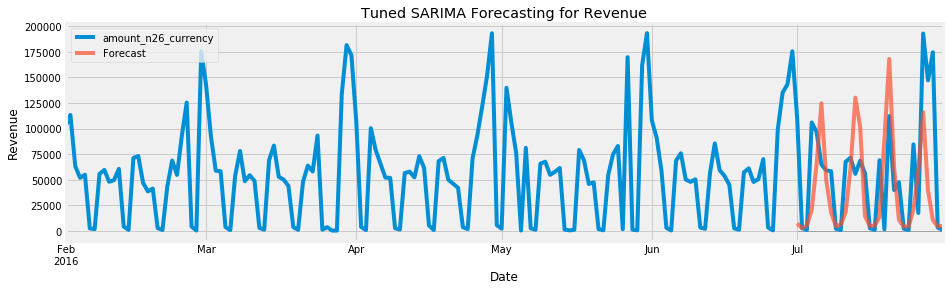

In [138]:
pred_ci = pred_rev.conf_int()
ax = y_rev.plot(label='observed')
np.exp(pred_rev.predicted_mean).plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.title('Tuned SARIMA Forecasting for Revenue')
plt.show()

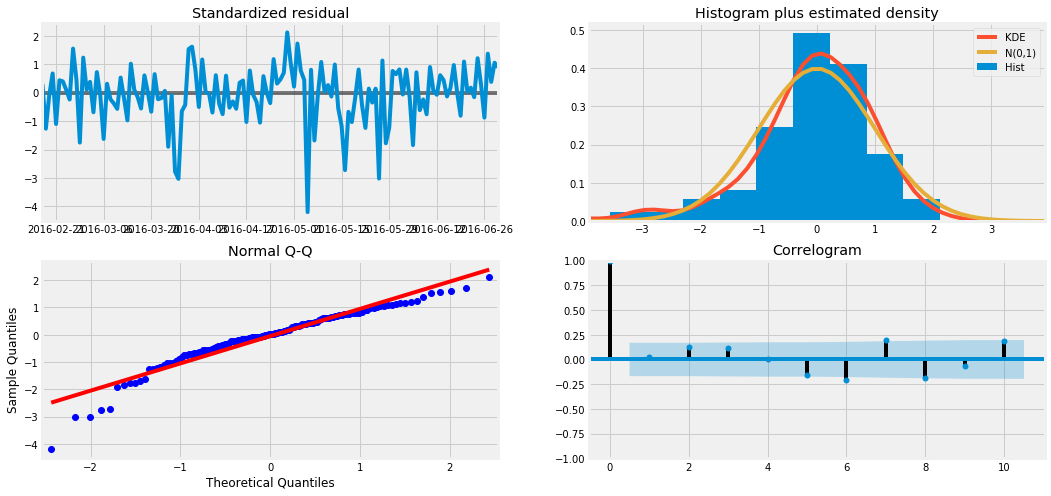

In [139]:
min_aic_model_rev.plot_diagnostics(figsize=(16, 8))
plt.show()

In [140]:
y_forecasted = pred_rev.predicted_mean.values
y_truth = y_rev[start_index:end_index].amount_n26_currency.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
evaluate_forecast(y_truth, y_forecasted)

The Mean Squared Error of our forecasts is 5877053914.37
The Root Mean Squared Error of our forecasts is 76661.95


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-1.090134,55364.722446,56091.716654,5.877054e+09,57.565866,99.675868,76661.945673


### c1. Auto ARIMA for Expenses 

In [93]:
model = auto_arima(y_exp_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_exp_train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=199.052, BIC=217.155, Fit time=0.834 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=203.601, BIC=209.635, Fit time=0.063 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=205.099, BIC=214.150, Fit time=0.063 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=205.158, BIC=214.209, Fit time=0.194 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=207.955, BIC=223.042, Fit time=0.283 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=211.541, BIC=232.662, Fit time=0.949 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=208.287, BIC=223.373, Fit time=1.009 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=202.968, BIC=224.089, Fit time=0.944 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=206.994, BIC=219.063, Fit time=0.645 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 1);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 2),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

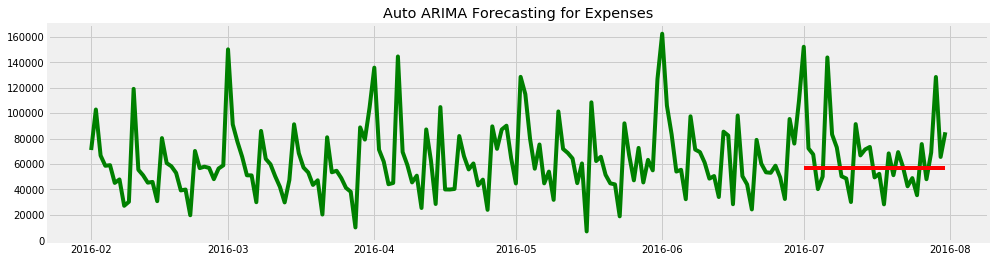

In [100]:
forecast = model.predict(n_periods=len(y_rev_val))
forecast = pd.DataFrame(forecast, index = y_exp_val.index, columns=['Prediction'])
forecast = np.exp(forecast)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(y_exp.amount_n26_currency, label='Train', color='g')
plt.plot(forecast, label='Prediction', color= 'r')
plt.title('Auto ARIMA Forecasting for Expenses')
plt.show()

In [96]:
evaluate_forecast(y_exp_val, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-2.265654e+10,58875.909578,58536.943141,3.470888e+09,72.169089,NaN,58914.242066


### c2. Auto SARIMA for Expenses

In [112]:
model = auto_arima(
    y_exp_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=14, stepwise=True
)
model.fit(y_exp_train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 14); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 14); AIC=203.601, BIC=209.635, Fit time=0.063 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 14); AIC=275.379, BIC=287.448, Fit time=2.224 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 14); AIC=196.424, BIC=208.493, Fit time=0.246 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 14); AIC=456.264, BIC=471.350, Fit time=1.913 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 14); AIC=205.158, BIC=214.209, Fit time=0.174 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 2, 14); AIC=177.293, BIC=192.379, Fit time=1.099 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 14); AIC=179.116, BIC=197.220, Fit time=7.307 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 2, 14); AIC=175.418, BIC=187.487, Fit time=0.947 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 2, 14);

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 2, 14), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [113]:
start_index = y_exp_val.index.min()
end_index = y_exp_val.index.max()
pred = model.predict()
pred = model.predict(n_periods=len(y_exp_val))
pred = pd.DataFrame(y_exp_val, index = y_exp_val.index, columns=['Prediction'])

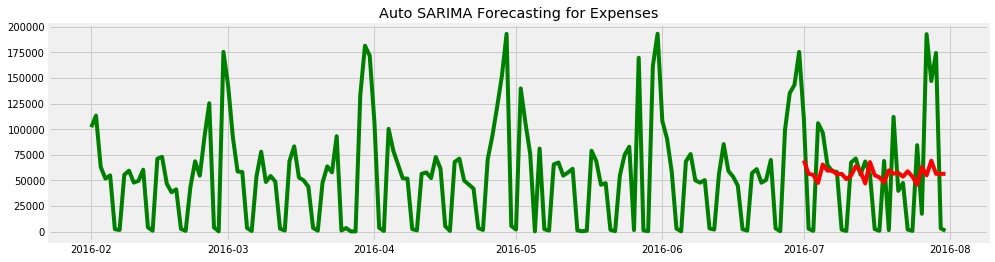

In [145]:
forecast_s = model.predict(n_periods=len(y_rev_val))
forecast_s = pd.DataFrame(forecast_s, index = y_rev_val.index,columns=['Prediction'])
forecast_s = np.exp(forecast_s)

fig, ax = plt.subplots(figsize=(15,4))
plt.plot(y_rev.amount_n26_currency, label='Train', color='g')
plt.plot(forecast_s, label='Prediction', color='r')
plt.title('Auto SARIMA Forecasting for Expenses')
plt.show()

In [115]:
evaluate_forecast(y_exp_val, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-2.095684e+10,56661.282563,56661.212785,3.210501e+09,71.529645,NaN,56661.282564


### c3. SARIMA Tuning for Expenses

In [122]:
min_aic_model_exp = sarima_tuning(y_exp_train, 3, 6)

C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1145.7826178773294
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:930.4133877221814


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 2, 6)12 - AIC:898.8333788828543
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:296.4946841185839
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:205.76105384555504


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 2, 6)12 - AIC:207.92380590636841
ARIMA(0, 0, 0)x(0, 2, 0, 6)12 - AIC:430.85981719501683


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 2, 1, 6)12 - AIC:294.3281340085637


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 2, 2, 6)12 - AIC:224.27513005933727
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:299.7473842087081
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:219.54553405145938


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 2, 6)12 - AIC:216.0572205482807
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:256.410389697448


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:207.76123368527595


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 2, 6)12 - AIC:208.00412447503393
ARIMA(0, 0, 0)x(1, 2, 0, 6)12 - AIC:342.8693900504386


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 2, 1, 6)12 - AIC:270.21959413297486


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 2, 2, 6)12 - AIC:226.2751638624359
ARIMA(0, 0, 0)x(2, 0, 0, 6)12 - AIC:258.40361231937345


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 6)12 - AIC:216.53712998461197


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 6)12 - AIC:214.07923008669076
ARIMA(0, 0, 0)x(2, 1, 0, 6)12 - AIC:246.03140653863943
ARIMA(0, 0, 0)x(2, 1, 1, 6)12 - AIC:206.25130277127226


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 2, 6)12 - AIC:202.94667422187104


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 0, 6)12 - AIC:307.5785001543969


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 1, 6)12 - AIC:261.36249003807734


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 2, 2, 6)12 - AIC:259.4901695768002
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:946.4157725422044


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:764.6440135656098


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 2, 6)12 - AIC:638.5598882773492
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:291.2722635554027


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:208.6580532580801


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 2, 6)12 - AIC:207.6998474655437
ARIMA(0, 0, 1)x(0, 2, 0, 6)12 - AIC:421.15900317959364


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 2, 1, 6)12 - AIC:292.5941693224547


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 2, 2, 6)12 - AIC:225.02156350233858
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:299.8517995733713


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:218.92568173118013


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 2, 6)12 - AIC:216.88393078860088
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:258.2648709089536
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:214.99106081633215


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 2, 6)12 - AIC:209.10386671480137
ARIMA(0, 0, 1)x(1, 2, 0, 6)12 - AIC:344.67013610661206


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 1, 6)12 - AIC:270.48993860716485


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 2, 2, 6)12 - AIC:235.48263195993223


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 0, 6)12 - AIC:260.25631912465997


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 6)12 - AIC:263.3954640493528


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 2, 6)12 - AIC:260.73777705390216
ARIMA(0, 0, 1)x(2, 1, 0, 6)12 - AIC:247.67445063012218
ARIMA(0, 0, 1)x(2, 1, 1, 6)12 - AIC:208.22318197534554


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 2, 6)12 - AIC:202.1818573528826


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 0, 6)12 - AIC:309.3539166847484


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 1, 6)12 - AIC:263.01639833202273


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 2, 2, 6)12 - AIC:259.2462246055086


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 0, 6)12 - AIC:802.2615995856413


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 1, 6)12 - AIC:727.3229326878156


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 0, 2, 6)12 - AIC:548.3047824578026
ARIMA(0, 0, 2)x(0, 1, 0, 6)12 - AIC:287.0378356099659


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 1, 6)12 - AIC:210.44636583005405


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 1, 2, 6)12 - AIC:206.25785669389379
ARIMA(0, 0, 2)x(0, 2, 0, 6)12 - AIC:411.294767465581


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 2, 1, 6)12 - AIC:288.7637557260431


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(0, 2, 2, 6)12 - AIC:226.30576047238398


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 0, 6)12 - AIC:298.68302164079296


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 1, 6)12 - AIC:292.3511729043769


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 0, 2, 6)12 - AIC:240.94775063325426
ARIMA(0, 0, 2)x(1, 1, 0, 6)12 - AIC:259.65397937933096
ARIMA(0, 0, 2)x(1, 1, 1, 6)12 - AIC:215.1407895826067


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 1, 2, 6)12 - AIC:205.75403575340624
ARIMA(0, 0, 2)x(1, 2, 0, 6)12 - AIC:346.3042599779791


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 1, 6)12 - AIC:269.9139474155416


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(1, 2, 2, 6)12 - AIC:228.3058575742989


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 0, 6)12 - AIC:261.64201131721666


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 6)12 - AIC:265.5763879313293


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 6)12 - AIC:272.55763095470667
ARIMA(0, 0, 2)x(2, 1, 0, 6)12 - AIC:247.6009246957448


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 1, 6)12 - AIC:207.83784024447317


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 1, 2, 6)12 - AIC:200.5451894081164


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 0, 6)12 - AIC:310.74091944988663


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 1, 6)12 - AIC:263.02345095209006


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 2)x(2, 2, 2, 6)12 - AIC:259.11834049665015
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:293.909704201512
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:282.2400849766668
ARIMA(0, 1, 0)x(0, 0, 2, 6)12 - AIC:270.7409661845902


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 0, 6)12 - AIC:410.6752125410062
ARIMA(0, 1, 0)x(0, 1, 1, 6)12 - AIC:292.8884088205227


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 2, 6)12 - AIC:285.28926081316786
ARIMA(0, 1, 0)x(0, 2, 0, 6)12 - AIC:553.835013166625


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 2, 1, 6)12 - AIC:401.14382675702484


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 2, 2, 6)12 - AIC:299.8335448850838
ARIMA(0, 1, 0)x(1, 0, 0, 6)12 - AIC:284.34001573886644


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 6)12 - AIC:282.05420790751134


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 2, 6)12 - AIC:272.251929836644
ARIMA(0, 1, 0)x(1, 1, 0, 6)12 - AIC:341.1283391854933


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 6)12 - AIC:295.19784193654004


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 6)12 - AIC:286.5335111417372
ARIMA(0, 1, 0)x(1, 2, 0, 6)12 - AIC:435.53353742463776


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 2, 1, 6)12 - AIC:350.7011661208131


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 2, 2, 6)12 - AIC:308.97866874175344
ARIMA(0, 1, 0)x(2, 0, 0, 6)12 - AIC:273.99885086737663


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 0, 1, 6)12 - AIC:273.43548380719596


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 0, 2, 6)12 - AIC:274.19487747313383
ARIMA(0, 1, 0)x(2, 1, 0, 6)12 - AIC:320.79398468698787


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 6)12 - AIC:285.91090162094804


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 2, 6)12 - AIC:286.3030261928909
ARIMA(0, 1, 0)x(2, 2, 0, 6)12 - AIC:382.4578497931655


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 1, 6)12 - AIC:332.58823309438867


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 2, 2, 6)12 - AIC:331.2074204958449
ARIMA(0, 1, 1)x(0, 0, 0, 6)12 - AIC:206.2740274361164


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 6)12 - AIC:204.4112875062312


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 2, 6)12 - AIC:193.25522364326724
ARIMA(0, 1, 1)x(0, 1, 0, 6)12 - AIC:299.63614116519557


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 6)12 - AIC:213.00123491340702


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 2, 6)12 - AIC:213.99525775826578
ARIMA(0, 1, 1)x(0, 2, 0, 6)12 - AIC:431.57380449813024


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 1, 6)12 - AIC:300.84489163079036


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 2, 2, 6)12 - AIC:232.05433778533435


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 6)12 - AIC:205.4959848360872


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 6)12 - AIC:205.19211001173093


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 2, 6)12 - AIC:192.22257378852004


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 6)12 - AIC:262.50536239790506


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 6)12 - AIC:214.89496472963287


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 6)12 - AIC:213.16916281720967


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 0, 6)12 - AIC:348.17075738899564


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 1, 6)12 - AIC:277.4464905934326


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 2, 2, 6)12 - AIC:233.56552821443458


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 0, 6)12 - AIC:197.0729324458239


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 6)12 - AIC:191.85430239412528


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 2, 6)12 - AIC:184.8768716581257


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 6)12 - AIC:252.07873965670018


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 6)12 - AIC:215.11761521541592


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 2, 6)12 - AIC:208.74418920272097


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 0, 6)12 - AIC:312.99533411755215


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 1, 6)12 - AIC:268.5972030681167


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 2, 2, 6)12 - AIC:265.9591785459261
ARIMA(0, 1, 2)x(0, 0, 0, 6)12 - AIC:206.318443894822


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 1, 6)12 - AIC:199.1980539052314


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 2, 6)12 - AIC:192.92121566091424


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 0, 6)12 - AIC:294.5364072117337


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 1, 6)12 - AIC:214.51374886252518


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 1, 2, 6)12 - AIC:208.0034000401002


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 0, 6)12 - AIC:422.19953520280876


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 1, 6)12 - AIC:294.55861929322157


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(0, 2, 2, 6)12 - AIC:231.96764646260985
ARIMA(0, 1, 2)x(1, 0, 0, 6)12 - AIC:207.4518970322722


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 1, 6)12 - AIC:201.1974052278233


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 0, 2, 6)12 - AIC:193.63232091783635


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 0, 6)12 - AIC:264.29154990466805


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 6)12 - AIC:221.19446601794874


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 6)12 - AIC:207.89507864287395


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 0, 6)12 - AIC:350.04169431536775


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 1, 6)12 - AIC:273.7439814867521


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(1, 2, 2, 6)12 - AIC:233.96771470117994


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 0, 6)12 - AIC:198.99164428051904


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 6)12 - AIC:193.68981053510547


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 6)12 - AIC:183.5658240701835


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 6)12 - AIC:253.6170196165594


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 1, 6)12 - AIC:217.08820027224664


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 1, 2, 6)12 - AIC:211.42382985812003


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 0, 6)12 - AIC:314.68464523455816


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 1, 6)12 - AIC:272.64588625028193


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 2)x(2, 2, 2, 6)12 - AIC:265.84632677428226
ARIMA(0, 2, 0)x(0, 0, 0, 6)12 - AIC:455.54711328928374
ARIMA(0, 2, 0)x(0, 0, 1, 6)12 - AIC:430.87279852062875


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 0, 2, 6)12 - AIC:413.4422874578478
ARIMA(0, 2, 0)x(0, 1, 0, 6)12 - AIC:575.8274039919161


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 1, 1, 6)12 - AIC:442.4914663107537


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 1, 2, 6)12 - AIC:421.0860611851758
ARIMA(0, 2, 0)x(0, 2, 0, 6)12 - AIC:715.9254974178623


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 2, 1, 6)12 - AIC:552.915042259587


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(0, 2, 2, 6)12 - AIC:434.7870519834103
ARIMA(0, 2, 0)x(1, 0, 0, 6)12 - AIC:433.54729286761454


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 0, 1, 6)12 - AIC:432.63918234761877


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 0, 2, 6)12 - AIC:415.4069317013883
ARIMA(0, 2, 0)x(1, 1, 0, 6)12 - AIC:486.06565721342616


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 1, 6)12 - AIC:436.67078495324006


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 1, 2, 6)12 - AIC:422.0977607825686
ARIMA(0, 2, 0)x(1, 2, 0, 6)12 - AIC:578.1800777081172


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 2, 1, 6)12 - AIC:488.08630496556043


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(1, 2, 2, 6)12 - AIC:437.36647848073864
ARIMA(0, 2, 0)x(2, 0, 0, 6)12 - AIC:417.77539910612927


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 0, 1, 6)12 - AIC:417.67021142141436


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 0, 2, 6)12 - AIC:417.43062529156833
ARIMA(0, 2, 0)x(2, 1, 0, 6)12 - AIC:456.20461644141375


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 1, 6)12 - AIC:422.74169100296075


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 1, 2, 6)12 - AIC:423.33354122347544


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 0, 6)12 - AIC:512.803147217455


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 1, 6)12 - AIC:461.6330871593592


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 0)x(2, 2, 2, 6)12 - AIC:457.9727224895645
ARIMA(0, 2, 1)x(0, 0, 0, 6)12 - AIC:297.4285889442741


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 0, 1, 6)12 - AIC:282.8914090271767


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 0, 2, 6)12 - AIC:273.0231189575087
ARIMA(0, 2, 1)x(0, 1, 0, 6)12 - AIC:410.7267386166672


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 1, 1, 6)12 - AIC:298.7586548495434


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 1, 2, 6)12 - AIC:287.38503086420087
ARIMA(0, 2, 1)x(0, 2, 0, 6)12 - AIC:552.3701308357802


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 1, 6)12 - AIC:402.7053697027194


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(0, 2, 2, 6)12 - AIC:306.66846246302254
ARIMA(0, 2, 1)x(1, 0, 0, 6)12 - AIC:290.34934896522816


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 1, 6)12 - AIC:284.9709920543301


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 0, 2, 6)12 - AIC:274.91079221602007


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 0, 6)12 - AIC:346.59724254594875


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 1, 6)12 - AIC:302.08181341191084


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 1, 2, 6)12 - AIC:287.55479842780437


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 0, 6)12 - AIC:440.1430167620915


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 1, 6)12 - AIC:353.5269707014762


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(1, 2, 2, 6)12 - AIC:315.8492117342974


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 0, 6)12 - AIC:279.96517747222623


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 1, 6)12 - AIC:279.08232210299997


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 0, 2, 6)12 - AIC:276.87861918925654


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 6)12 - AIC:326.28086124857094


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 1, 6)12 - AIC:294.43019465469115


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 1, 2, 6)12 - AIC:290.8775315299423


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 0, 6)12 - AIC:387.3021058800319


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 1, 6)12 - AIC:341.71376688139753


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 1)x(2, 2, 2, 6)12 - AIC:336.1579227049248


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 0, 6)12 - AIC:216.07705179820766


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 1, 6)12 - AIC:210.0447857109365


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 0, 2, 6)12 - AIC:201.29759973857455


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 0, 6)12 - AIC:305.37042128973627


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 1, 6)12 - AIC:224.03356269678125


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 1, 2, 6)12 - AIC:217.07751232659237


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 0, 6)12 - AIC:435.5597667949972


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 1, 6)12 - AIC:305.33133080407674


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(0, 2, 2, 6)12 - AIC:241.32750263691509


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 0, 6)12 - AIC:214.4601241296882


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 1, 6)12 - AIC:210.67871436993613


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 0, 2, 6)12 - AIC:201.72665971292145
ARIMA(0, 2, 2)x(1, 1, 0, 6)12 - AIC:275.2379506657312


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 1, 1, 6)12 - AIC:225.4959229886527
ARIMA(0, 2, 2)x(1, 1, 2, 6)12 - AIC:214.5754793268953


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 0, 6)12 - AIC:359.9116015107164


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(1, 2, 1, 6)12 - AIC:284.71507157559375


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(1, 2, 2, 6)12 - AIC:242.89969378418843


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 0, 6)12 - AIC:208.68574701681746


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 6)12 - AIC:204.30256456576626


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 0, 2, 6)12 - AIC:203.7051542552062
ARIMA(0, 2, 2)x(2, 1, 0, 6)12 - AIC:264.7489945858717


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 1, 6)12 - AIC:268.4424470737817


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 1, 2, 6)12 - AIC:221.34938622322278
ARIMA(0, 2, 2)x(2, 2, 0, 6)12 - AIC:325.10901961668253


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 2, 1, 6)12 - AIC:279.6649163334247


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 2, 2)x(2, 2, 2, 6)12 - AIC:274.5504583236373
ARIMA(1, 0, 0)x(0, 0, 0, 6)12 - AIC:297.10801320902715
ARIMA(1, 0, 0)x(0, 0, 1, 6)12 - AIC:285.9619653177149


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 2, 6)12 - AIC:273.7184867577654
ARIMA(1, 0, 0)x(0, 1, 0, 6)12 - AIC:296.0671305025671


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 6)12 - AIC:207.50019241809593


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 2, 6)12 - AIC:209.65946506105755
ARIMA(1, 0, 0)x(0, 2, 0, 6)12 - AIC:423.69107679228557


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 1, 6)12 - AIC:293.54969242299455


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 2, 2, 6)12 - AIC:225.72941210646084


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 6)12 - AIC:297.9861915654598


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 6)12 - AIC:221.16988090604673


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 2, 6)12 - AIC:217.94658911809387
ARIMA(1, 0, 0)x(1, 1, 0, 6)12 - AIC:257.2736763790857
ARIMA(1, 0, 0)x(1, 1, 1, 6)12 - AIC:216.49558227435273


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 2, 6)12 - AIC:209.83128773121183
ARIMA(1, 0, 0)x(1, 2, 0, 6)12 - AIC:342.85063463245297


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 1, 6)12 - AIC:272.0576730263713


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 2, 2, 6)12 - AIC:227.72944562553792


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 0, 6)12 - AIC:259.27000922072335


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 6)12 - AIC:275.41915725779234


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 6)12 - AIC:215.94674234713983


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 0, 6)12 - AIC:246.77055660768966


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 1, 6)12 - AIC:207.14579036559033


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 2, 6)12 - AIC:204.51536661174904


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 0, 6)12 - AIC:307.8184996710885


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 1, 6)12 - AIC:261.35719154981786


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 2, 2, 6)12 - AIC:261.019801824109


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 6)12 - AIC:208.6311318211844
ARIMA(1, 0, 1)x(0, 0, 1, 6)12 - AIC:206.22574843945765


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 2, 6)12 - AIC:196.10655549709332
ARIMA(1, 0, 1)x(0, 1, 0, 6)12 - AIC:291.6234281657663


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 6)12 - AIC:208.4345962680241


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 2, 6)12 - AIC:209.03921791831849
ARIMA(1, 0, 1)x(0, 2, 0, 6)12 - AIC:419.0846113555093


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 2, 1, 6)12 - AIC:293.1638733332816


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 2, 2, 6)12 - AIC:226.43369310847956


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 6)12 - AIC:206.30937848982808


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 6)12 - AIC:212.09341276279318
ARIMA(1, 0, 1)x(1, 0, 2, 6)12 - AIC:207.6137176736696


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 6)12 - AIC:259.1404486533405


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 6)12 - AIC:210.43475402948394


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 6)12 - AIC:210.83303279780554


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 6)12 - AIC:344.7979135553926


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 1, 6)12 - AIC:272.328188631528


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 2, 2, 6)12 - AIC:228.85139185211216


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 6)12 - AIC:197.5773655152003


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 6)12 - AIC:192.49273479456767


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 6)12 - AIC:216.60184067842516
ARIMA(1, 0, 1)x(2, 1, 0, 6)12 - AIC:248.5467963260026


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 6)12 - AIC:209.11451151480347


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 2, 6)12 - AIC:203.79393866242012


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 0, 6)12 - AIC:308.74258280729333


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 1, 6)12 - AIC:263.13686666779444


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 2, 2, 6)12 - AIC:261.1327170295551


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 0, 6)12 - AIC:207.91524352288798


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 1, 6)12 - AIC:206.78563826891707


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 6)12 - AIC:197.33251953264298
ARIMA(1, 0, 2)x(0, 1, 0, 6)12 - AIC:288.5691534977257


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 1, 6)12 - AIC:212.32294412836114


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 1, 2, 6)12 - AIC:206.89172892451506


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 0, 6)12 - AIC:398.2024233991791


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 1, 6)12 - AIC:290.26350095461436


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(0, 2, 2, 6)12 - AIC:227.69849101557085


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 0, 6)12 - AIC:207.88228051426907


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 6)12 - AIC:213.85611609822485


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 6)12 - AIC:203.4109830971143
ARIMA(1, 0, 2)x(1, 1, 0, 6)12 - AIC:260.68852103286963


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 1, 6)12 - AIC:216.98516057506427


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 6)12 - AIC:207.5504533861889


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 6)12 - AIC:345.8084744445125


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 1, 6)12 - AIC:271.9119857566143


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(1, 2, 2, 6)12 - AIC:229.69856030573183


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 6)12 - AIC:199.54027077535906


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 6)12 - AIC:194.15240827179292


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 6)12 - AIC:209.49383926859258


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 6)12 - AIC:248.36268201383012


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 6)12 - AIC:208.49872846051977


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 6)12 - AIC:202.52445890925605


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 0, 6)12 - AIC:311.1037750414094


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 1, 6)12 - AIC:263.04567706310144


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 2)x(2, 2, 2, 6)12 - AIC:261.0693781189981
ARIMA(1, 1, 0)x(0, 0, 0, 6)12 - AIC:251.98538130377392
ARIMA(1, 1, 0)x(0, 0, 1, 6)12 - AIC:248.15399459198258


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 2, 6)12 - AIC:235.099148058526
ARIMA(1, 1, 0)x(0, 1, 0, 6)12 - AIC:342.029555498739


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 6)12 - AIC:253.29936925218666


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 2, 6)12 - AIC:253.17826397554268
ARIMA(1, 1, 0)x(0, 2, 0, 6)12 - AIC:468.3921966731866


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 2, 1, 6)12 - AIC:336.15507305165596


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 2, 2, 6)12 - AIC:265.5651628455035
ARIMA(1, 1, 0)x(1, 0, 0, 6)12 - AIC:248.14703070468346
ARIMA(1, 1, 0)x(1, 0, 1, 6)12 - AIC:249.8340069662765


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 2, 6)12 - AIC:234.33202680510334
ARIMA(1, 1, 0)x(1, 1, 0, 6)12 - AIC:303.99991808872625


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 6)12 - AIC:255.29943654002867


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 6)12 - AIC:253.87357007582966
ARIMA(1, 1, 0)x(1, 2, 0, 6)12 - AIC:391.884701339508


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 1, 6)12 - AIC:316.59457266954894


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 2, 2, 6)12 - AIC:267.56526785000534
ARIMA(1, 1, 0)x(2, 0, 0, 6)12 - AIC:235.849321130271


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 6)12 - AIC:233.35070333488358


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 2, 6)12 - AIC:235.34162954310708
ARIMA(1, 1, 0)x(2, 1, 0, 6)12 - AIC:286.07747844182705


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 6)12 - AIC:248.5735749159434


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 6)12 - AIC:249.49995702034124


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 0, 6)12 - AIC:348.0299847575914


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 2, 1, 6)12 - AIC:298.6171337393306


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 2, 2, 6)12 - AIC:276.71027490906624
ARIMA(1, 1, 1)x(0, 0, 0, 6)12 - AIC:207.73366467943026


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 6)12 - AIC:206.05383106255573


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 2, 6)12 - AIC:195.16590498505042


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 6)12 - AIC:299.4352851622806


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 6)12 - AIC:214.73517664558386


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 2, 6)12 - AIC:215.82948795246014


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 0, 6)12 - AIC:424.86212735564806


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 1, 6)12 - AIC:300.3689973626888


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 2, 2, 6)12 - AIC:233.5507927157896


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 6)12 - AIC:205.85704051184064


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 6)12 - AIC:206.92435759442276


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 2, 6)12 - AIC:194.2213710710994


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 6)12 - AIC:262.74716980728596


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 6)12 - AIC:222.87874325621874


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 6)12 - AIC:215.10488039098576


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 0, 6)12 - AIC:347.7331356100211


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 1, 6)12 - AIC:279.2688996281608


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 2, 2, 6)12 - AIC:235.50124891182526


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 0, 6)12 - AIC:198.03332517502935


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 6)12 - AIC:193.27511725925723


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 6)12 - AIC:184.01054662989435


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 6)12 - AIC:251.99799319230516


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 6)12 - AIC:215.15023093233106


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 2, 6)12 - AIC:217.31941546888316
ARIMA(1, 1, 1)x(2, 2, 0, 6)12 - AIC:312.49852529584575


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 1, 6)12 - AIC:270.21692079206093


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 2, 2, 6)12 - AIC:267.45541786624614


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 0, 6)12 - AIC:208.4525749479066


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 1, 6)12 - AIC:201.25952200754932


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 2, 6)12 - AIC:195.1264696648553
ARIMA(1, 1, 2)x(0, 1, 0, 6)12 - AIC:290.3529404454704


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 1, 6)12 - AIC:215.14280216135484


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 1, 2, 6)12 - AIC:209.8957388848424


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 0, 6)12 - AIC:419.84918100908635


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 1, 6)12 - AIC:295.27887801057204


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(0, 2, 2, 6)12 - AIC:233.74027753080034


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 0, 6)12 - AIC:208.05596655783347


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 1, 6)12 - AIC:203.24726490669588


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 0, 2, 6)12 - AIC:195.54859685215578
ARIMA(1, 1, 2)x(1, 1, 0, 6)12 - AIC:258.55662951229675


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 6)12 - AIC:217.12038013507083


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 6)12 - AIC:208.36887263992702


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 6)12 - AIC:341.9228589804021


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(1, 2, 1, 6)12 - AIC:275.5313654420603


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 2, 6)12 - AIC:236.65127138355052


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 0, 6)12 - AIC:199.76446878109408


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 6)12 - AIC:194.45537138144783


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 6)12 - AIC:184.74947141172208
ARIMA(1, 1, 2)x(2, 1, 0, 6)12 - AIC:248.7467011869063


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 6)12 - AIC:251.83009168695963


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 6)12 - AIC:210.43829585932116


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 0, 6)12 - AIC:308.3976626284497


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 1, 6)12 - AIC:268.97608189824825


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 2)x(2, 2, 2, 6)12 - AIC:265.1082055812848
ARIMA(1, 2, 0)x(0, 0, 0, 6)12 - AIC:359.71880380829407
ARIMA(1, 2, 0)x(0, 0, 1, 6)12 - AIC:350.28134955185664


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 0, 2, 6)12 - AIC:332.3223795140649
ARIMA(1, 2, 0)x(0, 1, 0, 6)12 - AIC:461.22502345588254


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 1, 1, 6)12 - AIC:352.4578530549295


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 1, 2, 6)12 - AIC:346.41916451815825
ARIMA(1, 2, 0)x(0, 2, 0, 6)12 - AIC:589.8277057523853


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 2, 1, 6)12 - AIC:445.3377600999246


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(0, 2, 2, 6)12 - AIC:354.67730392937784
ARIMA(1, 2, 0)x(1, 0, 0, 6)12 - AIC:350.7871370596247


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 0, 1, 6)12 - AIC:349.7579621859429


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 0, 2, 6)12 - AIC:333.6277750603026
ARIMA(1, 2, 0)x(1, 1, 0, 6)12 - AIC:407.73242625888247


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 1, 6)12 - AIC:361.1075039220399


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 1, 2, 6)12 - AIC:349.2276364285214
ARIMA(1, 2, 0)x(1, 2, 0, 6)12 - AIC:500.3262647293076


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 1, 6)12 - AIC:415.82552711786605


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(1, 2, 2, 6)12 - AIC:369.45432416851196
ARIMA(1, 2, 0)x(2, 0, 0, 6)12 - AIC:333.0600715930019


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 6)12 - AIC:333.17801156924685


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 0, 2, 6)12 - AIC:335.03586775965164


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 0, 6)12 - AIC:374.9366741141422


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 1, 6)12 - AIC:341.87732757978995


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 1, 2, 6)12 - AIC:343.69668269937324


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 0, 6)12 - AIC:443.06514410879737


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 1, 6)12 - AIC:383.65893729303167


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 0)x(2, 2, 2, 6)12 - AIC:370.94639298444594
ARIMA(1, 2, 1)x(0, 0, 0, 6)12 - AIC:256.93713618237814


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 0, 1, 6)12 - AIC:246.57165883833898


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 0, 2, 6)12 - AIC:237.99389031427347
ARIMA(1, 2, 1)x(0, 1, 0, 6)12 - AIC:342.63266582845233


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 1, 6)12 - AIC:260.5130266479504


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 1, 2, 6)12 - AIC:254.2663360742636
ARIMA(1, 2, 1)x(0, 2, 0, 6)12 - AIC:467.5052986227357


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 1, 6)12 - AIC:339.73506208007734


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(0, 2, 2, 6)12 - AIC:273.3443467518017


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 0, 6)12 - AIC:254.34594883778797


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 1, 6)12 - AIC:250.43848590740566


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 0, 2, 6)12 - AIC:239.30636089147208


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 0, 6)12 - AIC:309.56131319712324


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 1, 6)12 - AIC:262.5133746557591


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 1, 2, 6)12 - AIC:253.82648277999846


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 0, 6)12 - AIC:396.5508142636555


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 1, 6)12 - AIC:321.01472186463855


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(1, 2, 2, 6)12 - AIC:275.3446574578764


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 0, 6)12 - AIC:242.07512875332617


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 1, 6)12 - AIC:240.8588488437046


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 0, 2, 6)12 - AIC:241.0812480077473


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 6)12 - AIC:291.64296600149163


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 1, 6)12 - AIC:257.84213918134884


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 1, 2, 6)12 - AIC:255.83467850191857


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 0, 6)12 - AIC:352.9201379901553


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 1, 6)12 - AIC:307.7428869656607


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 1)x(2, 2, 2, 6)12 - AIC:277.8967278590335
ARIMA(1, 2, 2)x(0, 0, 0, 6)12 - AIC:217.53531711379833


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 1, 6)12 - AIC:211.4468658194922


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 2, 6)12 - AIC:203.18695574926664


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 0, 6)12 - AIC:305.61094467710507


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 1, 6)12 - AIC:225.31571425482196


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 1, 2, 6)12 - AIC:218.24176920873904


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 0, 6)12 - AIC:429.619295273445


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 1, 6)12 - AIC:306.2343724126477


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(0, 2, 2, 6)12 - AIC:242.21034737658252


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 0, 6)12 - AIC:215.5709204436987


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 1, 6)12 - AIC:212.20471300540908


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 0, 2, 6)12 - AIC:203.72210181533868
ARIMA(1, 2, 2)x(1, 1, 0, 6)12 - AIC:274.16047966658743


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 1, 6)12 - AIC:226.96973082782733


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 1, 2, 6)12 - AIC:216.03791915026164


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 6)12 - AIC:358.47030430538774


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(1, 2, 1, 6)12 - AIC:285.7505396341513


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 2, 6)12 - AIC:246.41899477757036


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 6)12 - AIC:208.26187237814804


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 6)12 - AIC:203.29820431419773


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 0, 2, 6)12 - AIC:205.74763268726974


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 6)12 - AIC:263.26648907722193


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 1, 1, 6)12 - AIC:229.2688906625411
ARIMA(1, 2, 2)x(2, 1, 2, 6)12 - AIC:222.1915428210968


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 2, 0, 6)12 - AIC:323.3173263328316


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 2, 2)x(2, 2, 1, 6)12 - AIC:278.81453110448143


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 2, 6)12 - AIC:275.69242247940474
ARIMA(2, 0, 0)x(0, 0, 0, 6)12 - AIC:253.94926728881364


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 6)12 - AIC:251.75641542928767


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 0, 2, 6)12 - AIC:237.80338572515691
ARIMA(2, 0, 0)x(0, 1, 0, 6)12 - AIC:290.40209721000775


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 1, 6)12 - AIC:211.57417645044458


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 2, 6)12 - AIC:211.01719121982256
ARIMA(2, 0, 0)x(0, 2, 0, 6)12 - AIC:417.40195670486855


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 1, 6)12 - AIC:293.0508840754975


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 2, 2, 6)12 - AIC:227.91464352099916
ARIMA(2, 0, 0)x(1, 0, 0, 6)12 - AIC:250.14557293781945


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 1, 6)12 - AIC:249.08549469350476


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 6)12 - AIC:237.14634429911064
ARIMA(2, 0, 0)x(1, 1, 0, 6)12 - AIC:257.91290888627304


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 1, 6)12 - AIC:211.93063286237765


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 2, 6)12 - AIC:211.30785603545368
ARIMA(2, 0, 0)x(1, 2, 0, 6)12 - AIC:342.65978073336896


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 1, 6)12 - AIC:271.9609360912815


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 2, 2, 6)12 - AIC:229.91512190275617


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 0, 6)12 - AIC:237.8493155271144


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 6)12 - AIC:235.3507664072817


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 2, 6)12 - AIC:237.34174364036167


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 6)12 - AIC:246.59576126519318


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 1, 6)12 - AIC:206.3059207455463


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 6)12 - AIC:202.94150899920947


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 0, 6)12 - AIC:307.12875928291


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 1, 6)12 - AIC:260.10551585749636


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 2, 2, 6)12 - AIC:261.0068758282159


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 0, 6)12 - AIC:210.22198794168904


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 1, 6)12 - AIC:210.4962931219698
ARIMA(2, 0, 1)x(0, 0, 2, 6)12 - AIC:199.12908922762776
ARIMA(2, 0, 1)x(0, 1, 0, 6)12 - AIC:291.67089274277026


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 6)12 - AIC:210.61560648628802


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 2, 6)12 - AIC:210.9246542094557


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 0, 6)12 - AIC:418.63235082498977


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 1, 6)12 - AIC:292.7807040728993


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 2, 2, 6)12 - AIC:227.93115184599114


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 0, 6)12 - AIC:207.6140589580986


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 6)12 - AIC:222.2954665659288


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 6)12 - AIC:219.31445298945437
ARIMA(2, 0, 1)x(1, 1, 0, 6)12 - AIC:259.8732718381493


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 6)12 - AIC:212.6170654012735


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 2, 6)12 - AIC:212.4369136966073


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 0, 6)12 - AIC:344.2792160297216


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 1, 6)12 - AIC:273.93533461397067


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 2, 2, 6)12 - AIC:239.41991770684314


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 6)12 - AIC:261.8990397494348


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 6)12 - AIC:195.15750035563008


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 6)12 - AIC:219.0008112445968
ARIMA(2, 0, 1)x(2, 1, 0, 6)12 - AIC:248.08596454667105


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 6)12 - AIC:208.24251586149654


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 6)12 - AIC:204.84710513831976


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 0, 6)12 - AIC:308.7408340571828


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 1, 6)12 - AIC:261.6259593911516


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 2, 2, 6)12 - AIC:262.93365903130893


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 0, 6)12 - AIC:210.91801801717267


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 1, 6)12 - AIC:208.64209321272193


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 0, 2, 6)12 - AIC:198.9594791788109
ARIMA(2, 0, 2)x(0, 1, 0, 6)12 - AIC:292.23366105944456


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 1, 6)12 - AIC:211.42648786945404


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 1, 2, 6)12 - AIC:211.93352247133345


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 0, 6)12 - AIC:382.3601790563778


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 1, 6)12 - AIC:292.56703646271455


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(0, 2, 2, 6)12 - AIC:229.5939662636754


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 6)12 - AIC:208.43671796802818


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 6)12 - AIC:211.33526982165546


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 6)12 - AIC:201.4869315033237
ARIMA(2, 0, 2)x(1, 1, 0, 6)12 - AIC:256.83783046296617


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 6)12 - AIC:216.2619219413911


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 1, 2, 6)12 - AIC:214.0767509705086


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 6)12 - AIC:328.5687894838703


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 1, 6)12 - AIC:260.2030519237337


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(1, 2, 2, 6)12 - AIC:231.73092419853316


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 6)12 - AIC:200.351847629835


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 6)12 - AIC:195.7270452756449
ARIMA(2, 0, 2)x(2, 0, 2, 6)12 - AIC:200.446090563115


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 6)12 - AIC:242.72856262117529


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 6)12 - AIC:208.91097535149373


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 6)12 - AIC:204.42486029628873
ARIMA(2, 0, 2)x(2, 2, 0, 6)12 - AIC:310.6649349148033


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 2)x(2, 2, 1, 6)12 - AIC:245.72112711022103


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 2, 6)12 - AIC:220.56918336109075
ARIMA(2, 1, 0)x(0, 0, 0, 6)12 - AIC:245.1725344112037
ARIMA(2, 1, 0)x(0, 0, 1, 6)12 - AIC:241.78727621513488


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 0, 2, 6)12 - AIC:230.7896918307996
ARIMA(2, 1, 0)x(0, 1, 0, 6)12 - AIC:325.6038735866069


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 1, 6)12 - AIC:248.60178552646852


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 2, 6)12 - AIC:247.4550586312805
ARIMA(2, 1, 0)x(0, 2, 0, 6)12 - AIC:444.62914717886946


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 2, 1, 6)12 - AIC:323.0923848391472


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 2, 2, 6)12 - AIC:262.6582258060971
ARIMA(2, 1, 0)x(1, 0, 0, 6)12 - AIC:241.12422511703346


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 1, 6)12 - AIC:242.78565561252776


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 2, 6)12 - AIC:228.16234868207243
ARIMA(2, 1, 0)x(1, 1, 0, 6)12 - AIC:292.98188999905636


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 6)12 - AIC:249.2078557874944


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 6)12 - AIC:248.55992541247338
ARIMA(2, 1, 0)x(1, 2, 0, 6)12 - AIC:370.5329569432038


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 1, 6)12 - AIC:305.30197503891236


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 2, 2, 6)12 - AIC:264.65822487779076
ARIMA(2, 1, 0)x(2, 0, 0, 6)12 - AIC:229.86943234383028


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 6)12 - AIC:223.49106911213886


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 6)12 - AIC:205.9812681457096


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 6)12 - AIC:281.8423982879319


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 6)12 - AIC:242.51486767692109


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 2, 6)12 - AIC:238.40160938240427


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 0, 6)12 - AIC:336.4797197464885


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 1, 6)12 - AIC:293.9706594326728


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 2, 2, 6)12 - AIC:294.66219855379245
ARIMA(2, 1, 1)x(0, 0, 0, 6)12 - AIC:208.7888407832561


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 1, 6)12 - AIC:207.5488059770734


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 2, 6)12 - AIC:196.49819958748162


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 0, 6)12 - AIC:297.938684359019


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 6)12 - AIC:217.0086370765907


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 2, 6)12 - AIC:217.32152971834518


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 0, 6)12 - AIC:423.55375369873434


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 1, 6)12 - AIC:299.1555110033936


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 2, 2, 6)12 - AIC:235.76818357335966


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 0, 6)12 - AIC:207.2693249012084


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 6)12 - AIC:207.96293556665344


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 2, 6)12 - AIC:195.57010428272088


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 6)12 - AIC:262.84665321070594


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 6)12 - AIC:224.5499577974966


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 6)12 - AIC:217.21797590515789


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 0, 6)12 - AIC:347.3626763039193


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 1, 6)12 - AIC:280.6568662864466


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 2, 2, 6)12 - AIC:237.76837421091082


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 6)12 - AIC:198.99969347742626


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 6)12 - AIC:193.49453903796876


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 6)12 - AIC:186.65769646890493
ARIMA(2, 1, 1)x(2, 1, 0, 6)12 - AIC:251.4483905400536


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 6)12 - AIC:214.1552282232005


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 6)12 - AIC:210.94377861896243


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 0, 6)12 - AIC:311.9712749210023


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 1, 6)12 - AIC:268.92556589824943


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 2, 2, 6)12 - AIC:269.20047377576157


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 0, 6)12 - AIC:209.4023737218924


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 1, 6)12 - AIC:201.9536233824292


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 0, 2, 6)12 - AIC:195.93820142022824


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 0, 6)12 - AIC:295.29517890241124


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 1, 6)12 - AIC:216.74209605729664


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 1, 2, 6)12 - AIC:211.37940377069893


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 0, 6)12 - AIC:420.234060135101


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(0, 2, 1, 6)12 - AIC:295.85310813704484
ARIMA(2, 1, 2)x(0, 2, 2, 6)12 - AIC:234.8416775315011


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 0, 6)12 - AIC:207.71875390750122


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 1, 6)12 - AIC:203.88313632670324


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 6)12 - AIC:196.763259847602


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 6)12 - AIC:264.8489588727158


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 6)12 - AIC:218.9214715825069


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 6)12 - AIC:211.0073126868259


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 0, 6)12 - AIC:349.52882637117335


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(1, 2, 1, 6)12 - AIC:277.21311637308077
ARIMA(2, 1, 2)x(1, 2, 2, 6)12 - AIC:236.8420149090956


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 6)12 - AIC:199.83646139036813


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 6)12 - AIC:195.27157986926113


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 6)12 - AIC:185.56088583556243
ARIMA(2, 1, 2)x(2, 1, 0, 6)12 - AIC:253.01254016966607


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 6)12 - AIC:216.16088150049393


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 1, 2, 6)12 - AIC:214.4841581065425


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 2)x(2, 2, 0, 6)12 - AIC:314.0694086287686
ARIMA(2, 1, 2)x(2, 2, 1, 6)12 - AIC:270.6411855298428


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 2, 6)12 - AIC:269.49024524857487
ARIMA(2, 2, 0)x(0, 0, 0, 6)12 - AIC:322.3101114277491
ARIMA(2, 2, 0)x(0, 0, 1, 6)12 - AIC:318.01985959192274


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 0, 2, 6)12 - AIC:299.44441453851573
ARIMA(2, 2, 0)x(0, 1, 0, 6)12 - AIC:404.0053331318863


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 1, 6)12 - AIC:322.5535725645552


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 1, 2, 6)12 - AIC:315.86934045925193
ARIMA(2, 2, 0)x(0, 2, 0, 6)12 - AIC:521.1675999726517


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 2, 1, 6)12 - AIC:397.4861507085905


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(0, 2, 2, 6)12 - AIC:330.65401198185396
ARIMA(2, 2, 0)x(1, 0, 0, 6)12 - AIC:311.47664694703667


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 0, 1, 6)12 - AIC:310.58769620001067


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 0, 2, 6)12 - AIC:298.4603675502799
ARIMA(2, 2, 0)x(1, 1, 0, 6)12 - AIC:369.49856569478084


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 1, 6)12 - AIC:322.2494901385156


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 1, 2, 6)12 - AIC:314.96677506539515


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 0, 6)12 - AIC:449.3362357003644


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 1, 6)12 - AIC:377.5656457171269


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(1, 2, 2, 6)12 - AIC:332.65405273129784


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 0, 6)12 - AIC:297.2951924314148


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 6)12 - AIC:296.34353951807736


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 0, 2, 6)12 - AIC:298.34241922422143


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 0, 6)12 - AIC:345.14277648322445


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 1, 6)12 - AIC:306.88386096645206


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 1, 2, 6)12 - AIC:308.8019083723957


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 0, 6)12 - AIC:408.7212550158213


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 0)x(2, 2, 1, 6)12 - AIC:355.45431810464544


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 2, 2, 6)12 - AIC:330.85851042969426
ARIMA(2, 2, 1)x(0, 0, 0, 6)12 - AIC:251.54692710079183


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 0, 1, 6)12 - AIC:240.55397176922642


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 0, 2, 6)12 - AIC:233.78237022088558


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 0, 6)12 - AIC:331.13572803448216


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 1, 6)12 - AIC:256.4254916691993


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 1, 2, 6)12 - AIC:248.34054818267754


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 0, 6)12 - AIC:447.23325063989626


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 1, 6)12 - AIC:328.479559235171


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(0, 2, 2, 6)12 - AIC:270.4833145874422


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 0, 6)12 - AIC:240.99689194192214


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 1, 6)12 - AIC:248.60100216810915


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 0, 2, 6)12 - AIC:233.71098564176066


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 0, 6)12 - AIC:298.4794157624925


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 1, 6)12 - AIC:258.4257148314969


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 1, 2, 6)12 - AIC:248.4667626259992


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 0, 6)12 - AIC:372.61675414969045


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 1, 6)12 - AIC:312.44893768498434


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(1, 2, 2, 6)12 - AIC:272.4833003085814


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 6)12 - AIC:235.98113489546927


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 6)12 - AIC:237.9157475268612


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 0, 2, 6)12 - AIC:213.55515056868785


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 0, 6)12 - AIC:285.09456540739785


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 1, 6)12 - AIC:250.45253457315096


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 1, 2, 6)12 - AIC:250.78860701629222


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 0, 6)12 - AIC:341.090222732868


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 1, 6)12 - AIC:302.07838627376975


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 1)x(2, 2, 2, 6)12 - AIC:302.57013418269537


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 0, 6)12 - AIC:254.98755199627618


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 1, 6)12 - AIC:239.34207459582052


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 2, 6)12 - AIC:232.2346184475938


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 0, 6)12 - AIC:313.7958131589303


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 1, 6)12 - AIC:258.1160987973497


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 1, 2, 6)12 - AIC:245.67395307282106


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 0, 6)12 - AIC:418.0796860501745


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 1, 6)12 - AIC:316.1122838372238


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(0, 2, 2, 6)12 - AIC:272.5939181990286


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 0, 6)12 - AIC:243.2965183956676
ARIMA(2, 2, 2)x(1, 0, 1, 6)12 - AIC:245.17136942135375


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 0, 2, 6)12 - AIC:232.7911517326


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 6)12 - AIC:294.7949763445108


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 1, 6)12 - AIC:260.1699711468085


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 1, 2, 6)12 - AIC:245.82645741786683


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 0, 6)12 - AIC:372.78029307067555


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(1, 2, 1, 6)12 - AIC:312.5951360305168


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 2, 2, 6)12 - AIC:275.4772786998815


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 6)12 - AIC:232.1547389072087


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 1, 6)12 - AIC:231.58130751390448


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 0, 2, 6)12 - AIC:225.58106376192333
ARIMA(2, 2, 2)x(2, 1, 0, 6)12 - AIC:277.131214809334


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 1, 6)12 - AIC:249.29248186106787


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 1, 2, 6)12 - AIC:247.828141765965


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 2, 0, 6)12 - AIC:335.1528256955751


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 2, 1, 6)12 - AIC:297.3574224522547


C:\Users\Chang_000\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(2, 2, 2)x(2, 2, 2, 6)12 - AIC:283.2835152091811


### c4. Results for Expenses

In [123]:
min_aic_model_exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:               amount_n26_currency   No. Observations:                  151
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 6)   Log Likelihood                 -84.783
Date:                           Tue, 19 Nov 2019   AIC                            183.566
Time:                                   19:54:54   BIC                            203.903
Sample:                               02-01-2016   HQIC                           191.830
                                    - 06-30-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1597      0.111    -10.440      0.000      -1.377      -0.942
ma.L2          0.1385      0.095      1.462      0.144      -0.047       0.324
ar.S.L6        1.1818      0.068     17.381      0.000       1.049       1.315
ar.S.L12      -0.9006      0.057    -15.918      0.000      -1.011      -0.790
ma.S.L6       -1.2714      0.150     -8.471      0.000      -1.566      -0.977
ma.S.L12       0.8284      0.153      5.426      0.000       0.529       1.128
sigma2         0.1684      0.018      9.620      0.000       0.134       0.203
===================================================================================
Ljung-Box (Q):                      113.40   Jarque-Bera (JB):                75.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.85
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [128]:
## Prediction in Expenses
start_index = y_exp_val.index.min()
end_index = y_exp_val.index.max()
pred_exp = min_aic_model_exp.get_prediction(start=start_index,end=end_index, dynamic=False)

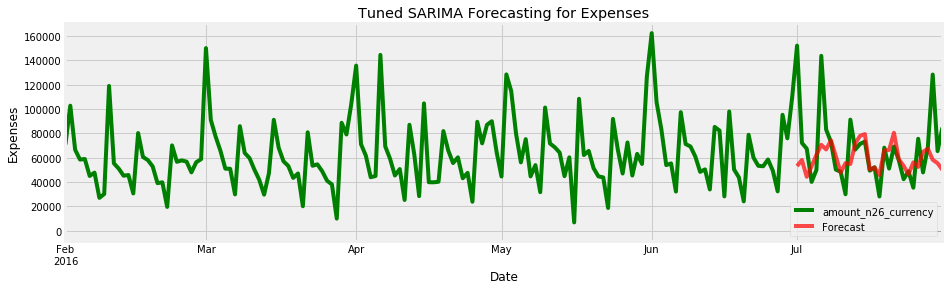

In [144]:
pred_ci = pred_exp.conf_int()
ax = y_exp.plot(label='observed', color='g')
np.exp(pred_exp.predicted_mean).plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4), color='r')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Expenses')
plt.legend()
plt.title('Tuned SARIMA Forecasting for Expenses')
plt.show()

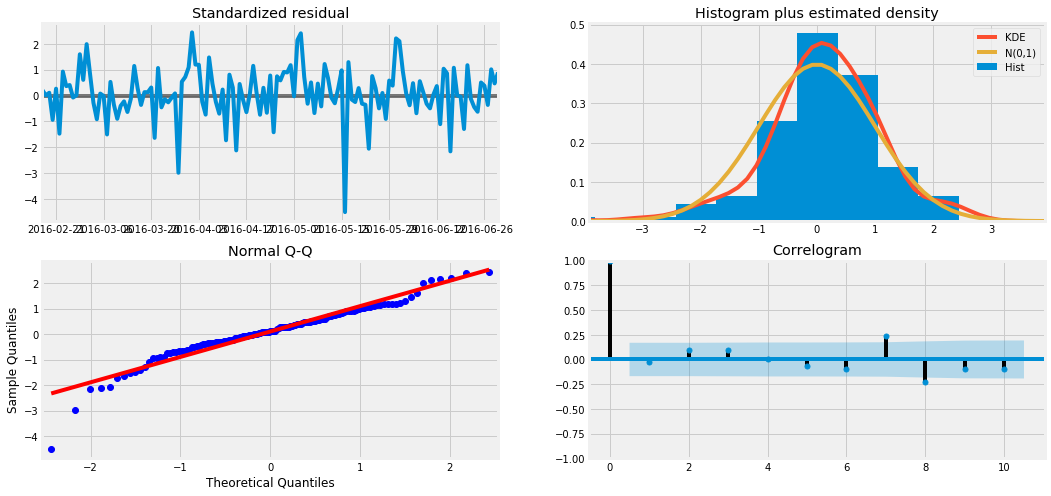

In [147]:
min_aic_model_exp.plot_diagnostics(figsize=(16, 8))
plt.show()

In [151]:
y_forecasted = pred_exp.predicted_mean.values
y_truth = y_exp[start_index:end_index].amount_n26_currency.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
evaluate_forecast(y_truth, y_forecasted)

The Mean Squared Error of our forecasts is 5377136536.81
The Root Mean Squared Error of our forecasts is 73328.96


,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-5.420906,67377.270833,66723.819667,5.377137e+09,73.337721,99.981031,73328.961105


### Appendix.

#### Feature Engineering for ML Method

- No testing data set available for this case.

##### a. transform `mcc_group, trans_type and agent` for dummy data

In [94]:
# df_onehotencoder = df_merge_meta[['mcc_group','trans_type','agent']].apply(lambda x: x.astype('category'))
# df_onhotencoder = pd.get_dummies(df_onehotencoder, prefix_sep='_', drop_first=True)

In [104]:
# drop_cols = ['month','mcc_group','trans_type','agent']
# df_dummy = df_merge_meta.drop(drop_cols, axis=1).join(df_onhotencoder)

##### b. agg for sum of amount and dummies

In [122]:
# sum_cols = list(df_dummy.drop(['user_id'], axis=1).columns)
# df_agg_for_sum_cols = df_dummy.groupby(['transaction_date','direction'])[sum_cols].sum().reset_index()

##### c. agg for number of users

In [110]:
# df_agg = df_dummy.groupby(['transaction_date','direction'])['user_id'].nunique().reset_index()

##### d. merge acitve users, amount and dummies into one df

In [153]:
# df_merge = df_agg.join(df_agg_for_sum_cols.drop(['transaction_date', 'direction'], axis=1))

##### e. normalise numeric features

In [160]:
# no_need_normalise_col = ['transaction_date','direction','amount_n26_currency']
# normalise_cols = df_merge.drop(no_need_normalise_col, axis=1)
# normalised_df = (normalise_cols - normalise_cols.min()) / (normalise_cols.max() - normalise_cols.min())
# normalised_df = df_merge[no_need_normalise_col].join(normalised_df)

##### f. split 2 data sets for revenue and expenses

In [165]:
# normalised_rev_df = normalised_df[normalised_df['direction'] == 'In'].drop('direction', axis=1)
# normalised_exp_df = normalised_df[normalised_df['direction'] == 'Out'].drop('direction', axis=1)